<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [1]:
!which python

/Users/fang/opt/anaconda3/bin/python


## EM_functions.py

## plot functions

In [2]:
import matplotlib.pyplot as plt

cmps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

def plot_t(Q,ax=None,t=None): 
    n,L,m=np.shape(Q)
    h=np.linspace(0,1,m)
    t_hat=np.sum(Q*h[None,None,:],axis=(-2,-1))
    weight=Q.reshape((n,-1))
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat):
    K=np.shape(theta)[1]-4
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    for i in range(K):
        ax[i].plot(theta[:,i],theta[:,i]);
        ax[i].plot(theta[:,i],theta_hat[:,i],'.');
        ax[i].set_title("a"+str(i+1))
        ax[i].set_xlabel("true values")

    ax[-4].plot(theta[:,-4],theta[:,-4]);
    ax[-4].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[-4].set_title("u0")
    ax[-4].set_ylabel("fitted values")
    ax[-4].set_xlabel("true values")

    ax[-3].plot(theta[:,-3],theta[:,-3]);
    ax[-3].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[-3].set_title("s0")
    ax[-3].set_ylabel("fitted values")
    ax[-3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");
    
    for i in range(K+4):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(theta,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    y = get_Y(theta, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    for i in range(p):
        ax[i,0].plot(t_hat,X[:,i,0],'.',color="gray");
        ax[i,0].plot(t_hat,y_hat[:,i,0],'b.', label = 'fit');
        ax[i,0].plot(t_hat,y[:,i,0],'r.',label = 'true');
        ax[i,0].set_title(gene_list[i]+" unspliced")

        ax[i,1].plot(t_hat,X[:,i,1],'.',color="gray");
        ax[i,1].plot(t_hat,y_hat[:,i,1],'b.', label = 'fit');
        ax[i,1].plot(t_hat,y[:,i,1],'r.', label = 'true');
        ax[i,1].set_title(gene_list[i]+" spliced")
        ax[i,1].legend()


def plot_theta_hat(theta_hat,K,gene_list=None):
    if gene_list is None:
        gene_list = np.arange(len(theta_hat))
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))
    ax[0].scatter(np.array(gene_list), theta_hat[:,0]);
    ax[-3].scatter(np.array(gene_list), theta_hat[:,-3]);
    for i in range(1,K+1):
        ax[i].scatter(np.array(gene_list), theta_hat[:,i]-theta_hat[:,0]);
        
    for i in range(-2,0):
        ax[i].scatter(np.array(gene_list), theta_hat[:,i]);

    ax[0].set_title("a1");
    ax[1].set_title("a2 - a1");
    ax[2].set_title("u0 - a1");
    ax[3].set_title("s0");
    ax[4].set_title("beta");
    ax[5].set_title("gamma");


def plot_y(X,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(2,p,figsize=(6*p,8))
    if p==1:
        i=0
        ax[0].scatter(t_hat,X[:,i,0],c=colors20[np.mod(clusters, 20)]);
        ax[0].plot(t_hat,y_hat[:,i,0],'r.');
        ax[0].set_title(gene_list[0]+" unspliced")

        ax[1].scatter(t_hat,X[:,i,1],c=colors20[np.mod(clusters, 20)]);
        ax[1].plot(t_hat,y_hat[:,i,1],'r.');
        ax[1].set_title(gene_list[0]+" spliced")
    else:
        for i in range(p):
            ax[0,i].scatter(t_hat,X[:,i,0],c=colors20[np.mod(clusters, 20)]);
            ax[0,i].plot(t_hat,y_hat[:,i,0],'r.');
            ax[0,i].set_title(gene_list[i]+" unspliced")

            ax[1,i].scatter(t_hat,X[:,i,1],c=colors20[np.mod(clusters, 20)]);
            ax[1,i].plot(t_hat,y_hat[:,i,1],'r.');
            ax[1,i].set_title(gene_list[i]+" spliced")

            
            
def plot_phase(X,theta_hat,Q,topo,tau,gene_list=None):
    if gene_list is None:
        gene_list = np.arange(len(theta_hat))
    n,L,m=Q.shape
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    fig, ax = plt.subplots(1,p,figsize=(6*p,4))
    if p==1:
        i=0
        ax.scatter(X[:,i,0],X[:,i,1],c='lightgray');
        ax.set_title(gene_list[0])

    else:
        for i in range(p):
            ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
            ax[i].set_title(gene_list[i])
    
    Y_hat = np.zeros((L,n,p,2))
    for l in range(L):
        t_hat=np.sum(Q[:,l,:]*h[None,:],axis=1)
        theta_l_hat = np.concatenate((theta_hat[:,topo[l]], theta_hat[:,-4:]), axis=1)
        Y_hat[l] = get_Y(theta_l_hat,t_hat,tau) # m*p*2
        y_hat = Y_hat[l]
        if p==1:
            i=0
            ax.scatter(y_hat[:,i,0],y_hat[:,i,1],c=t_hat,cmap=cmps[l]);
        else:
            for i in range(p):
                ax[i].scatter(y_hat[:,i,0],y_hat[:,i,1],c=t_hat,cmap=cmps[l]);
                         

In /Users/fang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/fang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/fang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/fang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/fang/opt/anaconda3/lib/python3.7/site-

# Test

Note that inference of $\alpha$ is much accurate than $\beta$ and $\gamma$, because even under a uniform prior when n is not too large, moving $\beta$ and $\gamma$ together with posterior a little bit does not change likelihood that much

In [3]:
%load_ext line_profiler

### Get_Y

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 16 21:20:50 2022

@author: Meichen Fang
"""

"""
Outline of traj_EM:
    n cells, p genes, m time grids, L lineages
    Given Q(z) which is a n*L*m array, compute optimal theta_j for each gene j:
        compute loss which is negative log likelihood + Regularization 
        negative log likelihood is a function of theta_j and Q(z)
        
"""
import numpy as np
from tqdm import tqdm
import time
from multiprocessing import Pool
from scipy.optimize import minimize
from scipy.special import logsumexp
import anndata as ad

# global parameters: upper and lower limits for numerical stability
eps = 1e-20

def get_Y_ori(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
        print(np.shape(theta)[1], K+4)
        raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]

    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d[:,None]*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)

    # nascent
    y1=y1_0[None,:]*np.exp(-beta[None,:]*t)  
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y1 = y1 + a[None,:,k-1] * (np.exp(- beta[None,:]*I[k,:,None] *(t-tau[k]))- np.exp(-beta[None,:]*I[k,:,None] * (t-tau[k-1])) ) \
          + a[None,:,k-1] * (1 - np.exp(- beta[None,:]*idx[:,None] *(t-tau[k-1]))) 
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    # mature + c * nascent 
    y=y_0[None,:]*np.exp(-gamma[None,:]*t)    
    for k in range(1,K+1):
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y = y + a_[None,:,k-1] * (np.exp(-gamma[None,:]*I[k,:,None] * (t-tau[k]))- np.exp(-gamma[None,:]*I[k,:,None] * (t-tau[k-1])) ) \
          +  a_[None,:,k-1] * (1 - np.exp(-gamma[None,:]*idx[:,None]*(t-tau[k-1]))) 

    Y = np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y


def get_Y(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
        print(np.shape(theta)[1], K+4)
        raise TypeError("wrong parameters lengths")
    a = theta[:,0:K].T
    beta = theta[:,-2].reshape((1,-1))
    gamma = theta[:,-1].reshape((1,-1))

    y1_0 = theta[:,-4].reshape((1,-1))
    y2_0 = theta[:,-3].reshape((1,-1))

    c = beta/(beta-gamma+eps)
    d = beta**2/((beta-gamma)*gamma+eps)
    y_0 = y2_0 + c*y1_0
    a_ = d*a
    t = t.reshape(-1,1)
    m = len(t)
  
    I = np.ones((K+1,m),dtype=bool)

    # nascent
    y1=y1_0*np.exp(-t@beta)
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y1 = y1 + a[None,k-1] * (np.exp(- (I[k,:,None] *(t-tau[k]))@beta)- np.exp(-(I[k,:,None]*(t-tau[k-1]))@beta )) \
          + a[None,k-1] * (1 - np.exp(- (idx[:,None] *(t-tau[k-1]))@beta ) )
    
    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    # mature + c * nascent 
    y=y_0*np.exp(-t@gamma)    
    for k in range(1,K+1):
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y = y + a_[None,k-1] * (np.exp(-(I[k,:,None] * (t-tau[k]))@gamma)- np.exp(-(I[k,:,None] * (t-tau[k-1]))@gamma )) \
          +  a_[None,k-1] * (1 - np.exp(-(idx[:,None]*(t-tau[k-1]))@gamma) )

    Y = np.zeros((m,p,2))
    Y[:,:,0] = y1
    Y[:,:,1] = y-c*y1
    
    Y[Y<0]=0
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y


def get_Y2(theta, t, tau):
    # theta: p*(K+4)
    # t: len m
    # tau: len K+1
    # return m * p * 2
    p = len(theta)
    K = len(tau)-1 # number of states
    if np.shape(theta)[1]!=K+4:
        raise TypeError("wrong parameters lengths")
    a = theta[:,0:K]
    beta = theta[:,-2]
    gamma = theta[:,-1]
    y1_0 = theta[:,-4]
    y2_0 = theta[:,-3]
    t = t.reshape(-1,1)
    m = len(t)
    I = np.ones((K+1,m),dtype=bool)
    
    # nascent
    y1=np.zeros((m,p))
    y1=y1+y1_0[None,:]*np.exp(-beta[None,:]*t)   
    for k in range(1,K+1):
        I[k] = np.squeeze(t > tau[k])
        idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
        y1[I[k]] = y1[I[k]] + a[None,:,k-1] * (np.exp(- beta[None,:]*(t[I[k]]-tau[k]))- np.exp(-beta[None,:]* (t[I[k]]-tau[k-1])) ) 
        y1[idx] = y1[idx] + a[None,:,k-1] * (1 - np.exp(- beta[None,:] *(t[idx]-tau[k-1]))) 

    if np.sum(np.isnan(y1)) != 0:
        raise ValueError("Nan in y1")
    Y =np.zeros((m,p,2))
    Y[:,:,0] = y1
    
    # mature + c * nascent 
    ## nondegenrate cases
    nondegenerate = np.abs(beta-gamma)>eps # indices of genes having similar gamma and beta
    if np.sum(nondegenerate)>0:
        y =np.zeros((m,np.sum(nondegenerate)))
        beta_, gamma_ = beta[nondegenerate], gamma[nondegenerate]
        c = beta_/(beta_-gamma_)
        d = beta_**2/((beta_-gamma_)*gamma_)
        y_0 = y2_0[nondegenerate] + c*y1_0[nondegenerate]
        a_ = d[:,None]*a[nondegenerate,:]

        y=y+y_0[None,:]*np.exp(-gamma_[None,:]*t)    
        for k in range(1,K+1):
            idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k
            y[I[k]] = y[I[k]] + a_[None,:,k-1] * (np.exp(-gamma_[None,:] * (t[I[k]]-tau[k]))- np.exp(-gamma_[None,:]*(t[I[k]]-tau[k-1])) )
            y[idx] = y[idx] +  a_[None,:,k-1] * (1 - np.exp(-gamma_[None,:]*(t[idx]-tau[k-1]))) 

        if np.sum(np.isnan(y)) != 0:
            raise ValueError("Nan in y")

        Y[:,nondegenerate,1] = y-c*y1[:,nondegenerate]
    
    ## nondegenrate cases
    degenerate = ~nondegenerate
    if np.sum(degenerate)>0:
        y = np.zeros((m,np.sum(degenerate)))
        y = y + y1_0[None,degenerate]*beta[None,degenerate]*t*np.exp(-beta[None,degenerate]*t) + y2_0[None,degenerate]*np.exp(-gamma[None,degenerate]*t) 
        for k in range(1,K+1):
            idx =I[k-1]*(~I[k]) # tau_{k-1} < t_i <= tau_k with a[k-1]
            y[I[k]] = y[I[k]] + a[None,degenerate,k-1]*beta[None,degenerate]*((t[I[k]]-tau[k])*(np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k])) - np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k-1]))))    
            y[I[k]] = y[I[k]] + a[None,degenerate,k-1] * (np.exp(- beta[None,degenerate]*(t[I[k]]-tau[k])) - np.exp(- beta[None,degenerate] *(t[I[k]]-tau[k-1])) \
                                             - beta[None,degenerate] *(tau[k]-tau[k-1])*np.exp(- beta[None,degenerate] *(t[I[k]]-tau[k-1])))
            y[idx] = y[idx] + a[None,degenerate,k-1] * (1 - np.exp(-beta[None,degenerate]*(t[idx]-tau[k-1]))\
                                             - beta[None,degenerate] *(t[idx]-tau[k-1])*np.exp(- beta[None,degenerate]*(t[idx]-tau[k-1]))) 
        Y[:,degenerate,1] = y
    
    if np.sum(np.isnan(Y)) != 0:
        raise ValueError("Nan in Y")
    return Y

def neglogL(theta, x, Q, t, tau, topo, penalty):
    # theta: length K+4
    # x: n*2
    # Q: n*L*m
    # t: len m
    # tau: len K+1
    logL = 0
    for l in range(len(topo)):
        theta_l = np.concatenate((theta[topo[l]], theta[-4:]))
        Y = get_Y(theta_l[None,:],t,tau)[:,0,:] # m*2
        weight_l = Q[:,l,:] #n*m
        x_weighted = weight_l.T@x # m*2
        marginal_weight =  weight_l.sum(axis=0)[:,None] # m*1
        logL += np.sum( x_weighted * np.log(eps + Y) - marginal_weight*Y )

    loss = - logL    

    ## L1 Regularization
    if penalty>0:
        for l in range(len(topo)): 
            loss += penalty * np.abs(theta[topo[l][0]]-theta[-4]) 
            for k in range(1,len(topo[l])):
                loss += penalty * np.abs(theta[topo[l][k]]-theta[topo[l][k-1]]) 
        loss += penalty * np.abs(theta[-3]*theta[-1]/theta[-2]-theta[-4]) 

    return loss

def neglogL_old(theta, x, Q, t, tau, topo, penalty=0):
    # theta: length K+4
    # x: n
    # Q: n*L*m
    # t: len m
    # tau: len K+1
    logL = 0
    K = len(tau) - 1
    for l in range(len(topo)):
        theta_l = np.concatenate((theta[topo[l]], theta[-4:]))
        Y = get_Y(theta_l[None,:],t,tau) # m*1*2
        Y = Y[None,:,0,:] # 1*m*2
        weight_l = Q[:,l,:,None] #n*m*1
        logL += np.sum( weight_l*(x[:,None,:] * np.log(eps + Y) - Y) )

    loss = - logL    

    ## L1 Regularization
    if penalty>0:
        for l in range(len(topo)): 
            loss += penalty * np.abs(theta[topo[l][0]]-theta[-4]) 
            for k in range(1,len(topo[l])):
                loss += penalty * np.abs(theta[topo[l][k]]-theta[topo[l][k-1]]) 
        loss += penalty * np.abs(theta[-3]*theta[-1]/theta[-2]-theta[-4]) 

    return loss

  
def neglogL_bg(theta_bg,theta_a,x,Q,t,tau,topo,penalty):
    theta = np.append(theta_a, theta_bg)
    loss = neglogL(theta,x,Q,t,tau,topo,penalty)
    return loss

def neglogL_a(theta_a,theta_bg,x,Q,t,tau,topo,penalty):
    theta = np.append(theta_a, theta_bg)
    loss = neglogL(theta,x,Q,t,tau,topo,penalty)
    return loss

def update_theta_j(theta0, x, Q, t, tau, topo, penalty, alternative, bnd=1000, bnd_beta=100, miter = 1000, alteriter = 20):
    bounds = [[0,bnd]]*len(theta0)
    bounds[-2:] = [[1/bnd_beta,bnd_beta]]*2
    if alternative:
        new_theta = theta0.copy()
        for i in range(alteriter):
            ## minimize wrt a
            res1 = minimize(neglogL_a, new_theta[:-2], args=(new_theta[-2:],x,Q,t,tau,topo,penalty), bounds = bounds[:-2], options={'maxiter': int(miter/alteriter/2),'disp': False}) 
            new_theta[:-2]=res1.x
            ## minimize wrt beta and gamma
            res2 = minimize(neglogL_bg, new_theta[-2:], args=(new_theta[:-2],x,Q,t,tau,topo,penalty), bounds = bounds[-2:], options={'maxiter': int(miter/alteriter/2),'disp': False}) 
            new_theta[-2:]=res2.x
    else:
        res = minimize(neglogL, theta0, args=(x,Q,t,tau,topo,penalty), bounds=bounds, options={'maxiter': miter,'disp': False}) 
        new_theta = res.x
    return new_theta

def simulate_data(topo,tau,n,p,random_seed=2022,loomfilepath=None):
    np.random.seed(random_seed)
    L=len(topo)
    n_states=len(set(topo.flatten()))
    t=np.linspace(tau[0],tau[-1],n)
    theta=np.zeros((p,n_states+4))
    for k in range(n_states+2):
        theta[:,k]=np.exp(np.random.uniform(0,5,size=p))
    theta[:,-2]=np.exp(np.random.uniform(0,3,size=p))
    theta[:,-1]=np.exp(np.random.uniform(0,3,size=p))

    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2

    X = np.random.poisson(Y)
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1))
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=np.repeat(t,L)
        adata.obs["celltype"]=np.arange(n*L)//n
        adata.uns["theta"]=theta
        adata.write_loom(loomfilepath)
    return theta, Y, X
    
class TI_model:
    """
    A object to store the data and parameters of a probabilitic trajectory inference model.
    
    
    Attributes
    ----------
    topo: 2D np.darray
    tau:     
    """

    def __init__(self, topo, tau):
        self.topo=topo
        self.tau=tau
        self.L=len(topo)
        self.n_states=len(set(topo.flatten()))
        return None
    
    def set_m(self,m):
        self.m=m
        self.t=np.linspace(self.tau[0],self.tau[-1],m)
    
    def _get_theta(self):
        return self.theta.copy()
    
    def _initialize_theta(self, X):
        p = X.shape[1]
        self.theta = np.ones((p,self.n_states+4))
        self.theta[:,0:-3]=np.mean(X[:,:,0],axis=0)[:,None]
        self.theta[:,-3]=np.mean(X[:,:,1],axis=0)
        self.theta[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)
        return 
    
    def _initialize_Q(self, n, seed):
        Q=np.random.uniform(0,1,(n,self.L,self.m))
        Q=Q/Q.sum(axis=(-2,-1),keepdims=True)
        return Q

    def update_theta(self,X,Q,penalty=0,alternative=False,parallel=False,n_threads=1,theta0=None, bnd=1000, bnd_beta=100):
        """
        M-step
        beta and gamma can not be equal
        """
        n,L,m = np.shape(Q)
        n,p,s=np.shape(X)
        if s!=2:
            raise TypeError("wrong parameters lengths")

        if not hasattr(self, 'theta'):
            self._initialize_theta(X)

        if parallel is True:
            Input_args = []
            for j in range(p):
                Input_args.append((self.theta[j], X[:,j], Q, self.t, self.tau, self.topo, penalty, alternative, bnd, bnd_beta))
            with Pool(n_threads) as pool:      
                new_theta = pool.starmap(update_theta_j, Input_args)
            new_theta = np.array(new_theta)
        else:
            new_theta = np.zeros((p,self.n_states+4))
            for j in range(p): 
                new_theta[j]=update_theta_j(self.theta[j], X[:,j], Q, self.t, self.tau, self.topo, penalty, alternative, bnd, bnd_beta)
                
        self.theta = new_theta
        return

    def update_weight(self,X):
        """
        return 3D array posterior Q
        """
        if not hasattr(self, 'theta'):
            raise ValueError("self.theta not defined")
            
        n,p,s=np.shape(X)
        Y = np.zeros((self.L,self.m,p,2))
        for l in range(self.L):
            theta_l = np.concatenate((self.theta[:,self.topo[l]], self.theta[:,-4:]), axis=1)
            Y[l] = get_Y(theta_l,self.t,self.tau) # m*p*2
        #logL =  np.sum(X[:,None,None,:,:] * np.log(Y[None,:]+eps) - Y[None,:], axis=(-2,-1)) # n*L*m*p*2 -> n*L*m
        logL = np.tensordot(X, np.log(eps + Y),axes=([-2,-1],[-2,-1]))
        logL -= np.sum(Y,axis = (-2,-1))
        #logL += np.log(self.prior_) where self.prior_ = 1/L/m
        lower_bound = np.mean(logsumexp(logL, axis=(-2,-1)))
        #Q = softmax(logL, axis=(-2,-1))
        a = np.amax(logL,axis=(-2,-1),keepdims=True)
        temp = np.exp(logL-a)
        Q = temp/temp.sum(axis=(-2,-1),keepdims=True)
        return Q, lower_bound
    
    def fit(self, X, Q, relative_penalty=0, epoch=10, alternative=False, tol=0.01, parallel=False, n_threads=1):
        """
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times
        X: n cells * p genes
        m grid of t=[0,1]
        """
        n, p, _ = np.shape(X)
        n, L, m = Q.shape
        penalty=relative_penalty*n
        
        self._initialize_theta(X)

        #self.prior_ = np.ones_like(Q)/L/m
        self.set_m(m)
        
        theta_hist=[] 
        weight_hist=[]
        lower_bounds=[]
        theta_hist.append(self._get_theta())
        weight_hist.append(Q.copy())

        alternative = False
        lower_bound = - np.inf
        self.converged = False
        time_start = time.time()
        for i in range(epoch):
            prev_lower_bound = lower_bound
            self.update_theta(X,Q,parallel=parallel,n_threads=n_threads)
            theta_hist.append(self._get_theta())
            Q, lower_bound = self.update_weight(X)
            weight_hist.append(Q.copy())
            lower_bounds.append(lower_bound)  
            #plot_phase(X,self.theta,Q,self.topo,self.tau)
            
            print(str(i)+" iteration: "+str(int(time.time()-time_start)),'s')
            # check converged
            change = lower_bound - prev_lower_bound
            if abs(change) < tol:
                self.converged = True
                break
                
        return theta_hist, weight_hist, lower_bounds
    
    def fit_(self, X, m, relative_penalty=0, n_init=3, epoch=10, alternative=False, tol=0.01, parallel=False, n_threads=1):
        """
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times
        X: n cells * p genes
        m grid of t=[0,1]
        """
        n, p, _ = np.shape(X)
        penalty=relative_penalty*n
        
        self._initialize_theta(X)
        self.set_m(m)
        
        elbos = []
        thetas = []
        alternative = False
        max_lower_bound = -np.inf
        for init in tqdm(range(n_init)):
            Q = self._initialize_Q(n, init)
            lower_bound = -np.inf
            self.converged = False
            for i in range(epoch):
                prev_lower_bound = lower_bound
                self.update_theta(X,Q,parallel=parallel,n_threads=n_threads)
                Q, lower_bound = self.update_weight(X)
                change = lower_bound - prev_lower_bound
                if abs(change) < tol:
                    self.converged = True
                    break
                
            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_theta = self._get_theta()
                
            plot_phase(X,self.theta,Q,self.topo,self.tau)    
            elbos.append(lower_bound)
            thetas.append(self._get_theta())
        self.theta = best_theta
        return
    
    def _compute_lower_bound(self,X,Q):
        n,p,s=np.shape(X)
        Y = np.zeros((self.L,self.m,p,2))
        for l in range(self.L):
            theta_l = np.concatenate((self.theta[:,self.topo[l]], self.theta[:,-4:]), axis=1)
            Y[l] = get_Y(theta_l,self.t,self.tau) # m*p*2
        #logL =  np.sum(X[:,None,None,:,:] * np.log(Y[None,:]+eps) - Y[None,:], axis=(-2,-1)) # n*L*m*p*2 -> n*L*m
        logL = np.tensordot(X, np.log(eps + Y), axes=([-2,-1],[-2,-1]))
        logL -= np.sum(Y,axis=(-2,-1))
        #logL += np.log(self.prior_) where self.prior_ = 1/L/m
        return np.mean(logsumexp(logL, axis=(-2,-1)))


## Test neglogL

In [199]:
#%% generate data

n = 1000
p = 10

tau = (0,1)
topo = np.array([[0],[1]])

traj = TI_model(topo,tau)
true_theta, Y, X = simulate_data(topo,tau,n,p,42)

In [200]:
Q=np.ones((2000,2,1000))/2/1000

In [202]:
%lprun -f neglogL_old neglogL_old(true_theta[0], X[:,0], Q, t, tau, topo, penalty=0)
neglogL_old(true_theta[0], X[:,0], Q, t, tau, topo, penalty=0)

-37585.899913539004

In [203]:
%lprun -f neglogL neglogL(true_theta[0], X[:,0], Q, t, tau, topo, penalty=0)
neglogL(true_theta[0], X[:,0], Q, t, tau, topo, penalty=0)

-37585.89991354051

In [13]:
%lprun -f get_Y_ori get_Y_ori(theta_l,t,tau)

In [14]:
%lprun -f get_Y get_Y(theta_l,t,tau)

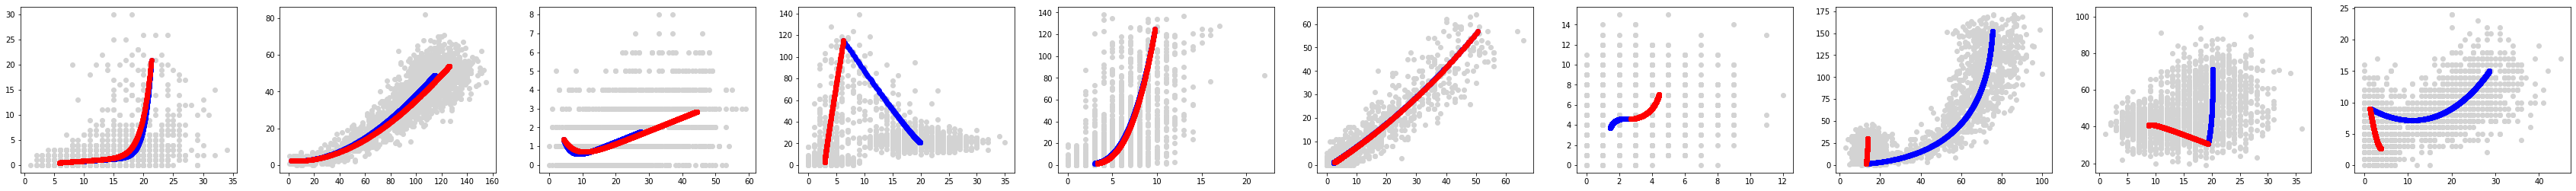

In [204]:
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
    ax[i].scatter(Y[:m,i,0],Y[:m,i,1],c='b');
    ax[i].scatter(Y[m:,i,0],Y[m:,i,1],c='r');

## Given true theta, it's able to find reasonable posterior

In [205]:
#%% generate data
np.random.seed(42)
n = 1000
p = 10

tau=(0,0.5,1)
topo = np.array([[0,1],[0,2]])

traj = TI_model(topo,tau)
traj.theta, Y, X = simulate_data(topo,tau,n,p,42)

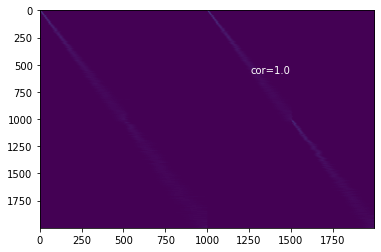

In [209]:
traj.set_m(n)
weight, elbo = traj.update_weight(X)
plot_t(weight, ax=None, t=np.append(t,t))

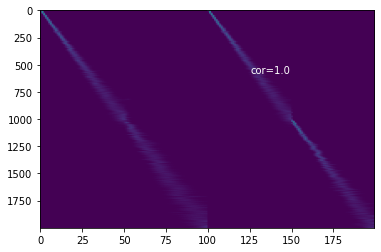

In [210]:
m=int(n/10)
traj.set_m(m)
weight, elbo = traj.update_weight(X)
plot_t(weight, ax=None, t=np.append(t,t))

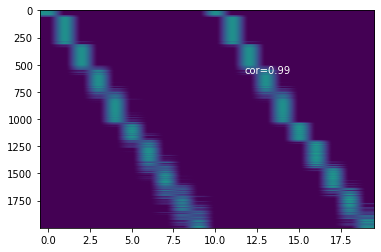

In [211]:
m=int(n/100)
traj.set_m(m)
weight, elbo = traj.update_weight(X)
plot_t(weight, ax=None, t=np.append(t,t))

## Given true time, it's able to estimate theta

In [7]:
#%% generate data
n = 1000
p = 20

tau=(0,1)
topo = np.array([[0],[1]])

true_theta, Y, X = simulate_data(topo,tau,n,p,42)

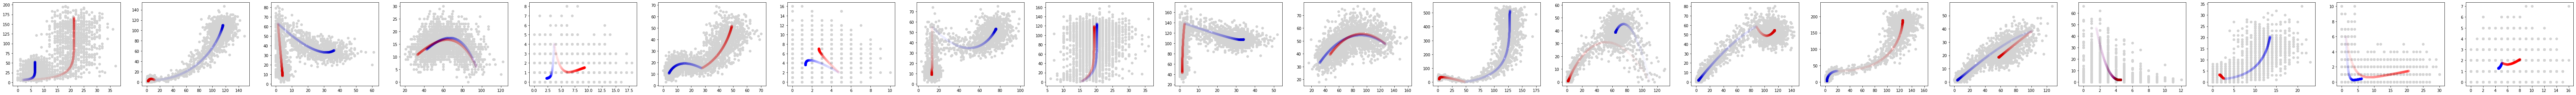

In [8]:
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
    ax[i].scatter(Y[:n,i,0],Y[:n,i,1],c='b',alpha=0.01);
    ax[i].scatter(Y[n:,i,0],Y[n:,i,1],c='r',alpha=0.01);

In [10]:
m=n
weight=np.diag(v=[1]*m)
weight1 = np.append(weight,np.zeros((m,m)),axis=0)
weight2 = np.append(np.zeros((m,m)),weight,axis=0)
Q=np.stack([weight1,weight2], axis=1)
Q=Q/Q.sum(axis=(-2,-1),keepdims=True)
Q.shape

(2000, 2, 1000)

In [375]:
#%% update theta
traj = TI_model(topo,tau)
traj.set_m(m)
%time traj.update_theta(X,Q)

CPU times: user 1min 34s, sys: 7.09 s, total: 1min 41s
Wall time: 25.8 s


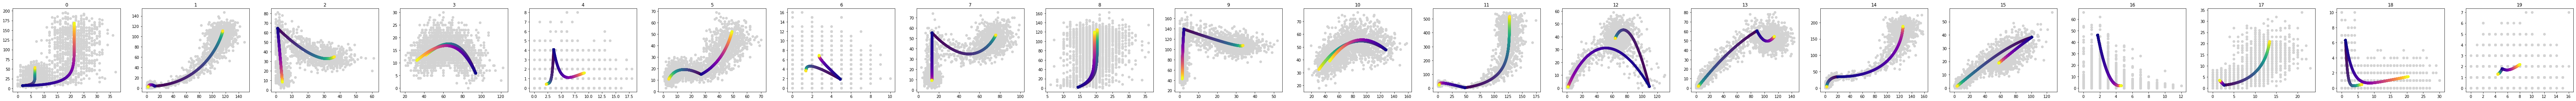

In [376]:
plot_phase(X,traj.theta,Q,topo,tau)

In [275]:
traj._compute_lower_bound(X, Q)

1017.685936105165

In [276]:
traj.theta=true_theta
traj._compute_lower_bound(X, Q)

1017.6810736593999

In [277]:
traj._initialize_theta(X)
traj._compute_lower_bound(X, Q)

923.0324993365454

## Test fit

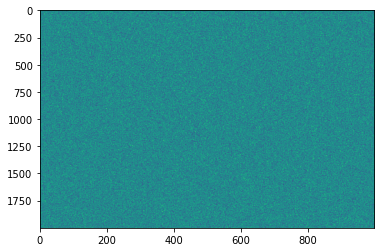

In [11]:
Q0=np.random.uniform(0,1,Q.shape)
Q0=Q0/Q0.sum(axis=(-2,-1),keepdims=True)
plt.imshow(Q0[:,0,:],aspect="auto");

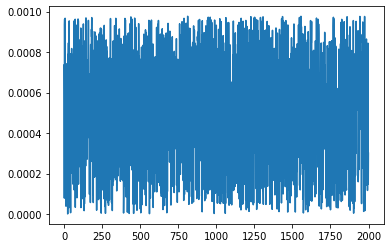

In [12]:
plt.plot(Q0[0].flatten())

0 iteration: 0 s
1 iteration: 2 s
2 iteration: 8 s
3 iteration: 11 s
4 iteration: 14 s
5 iteration: 16 s
6 iteration: 17 s
7 iteration: 19 s


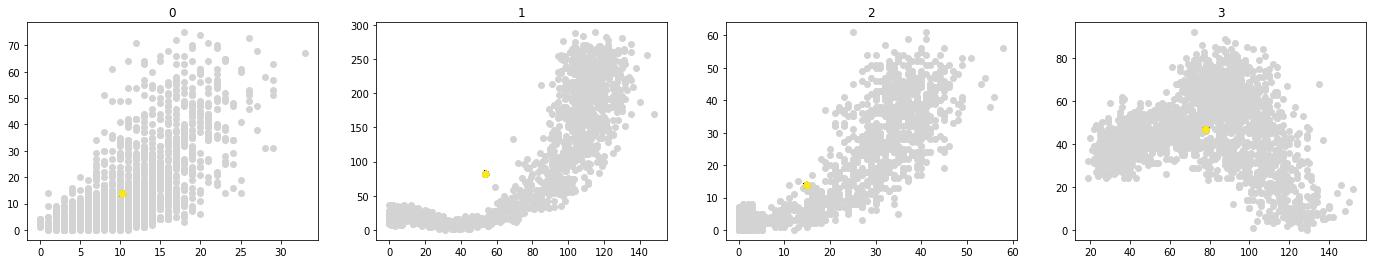

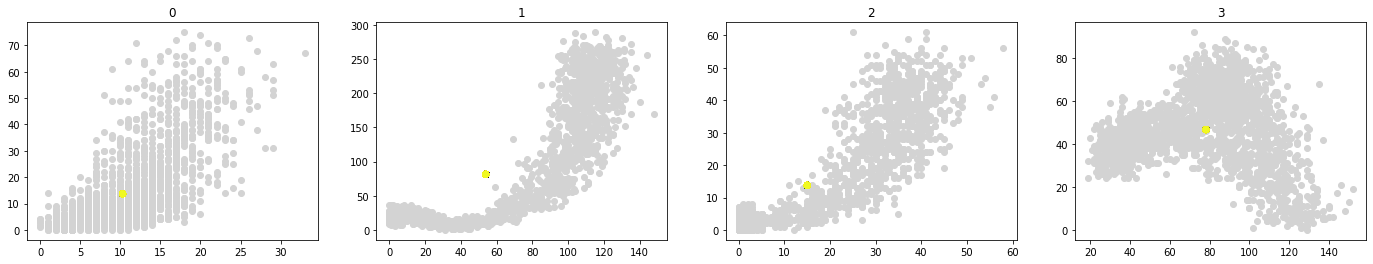

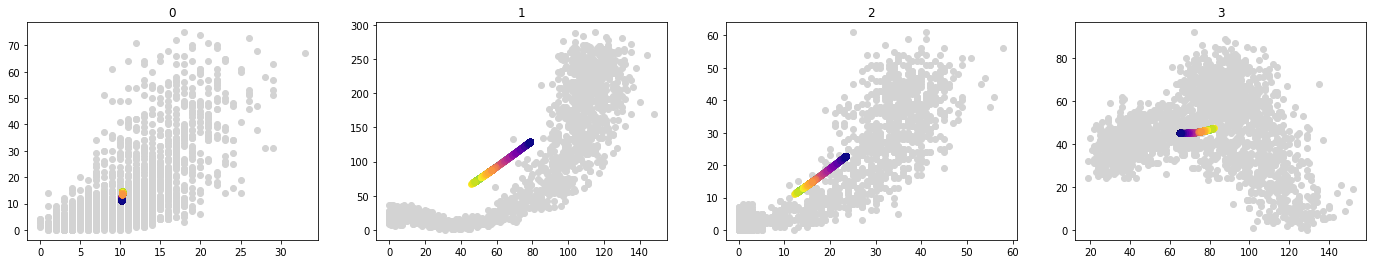

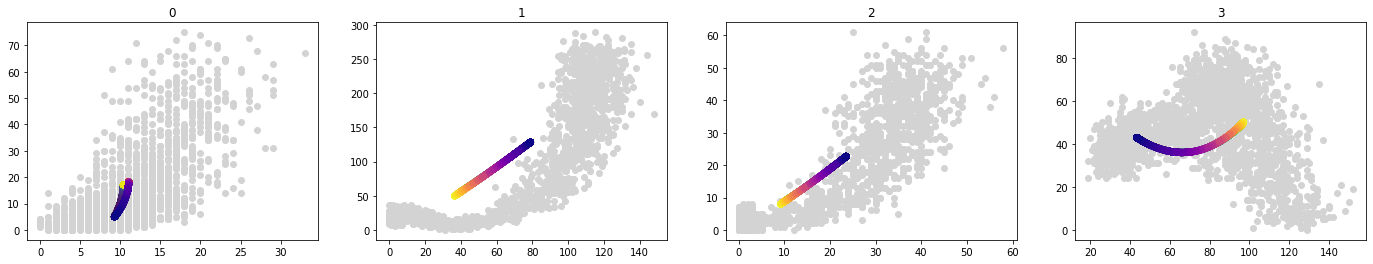

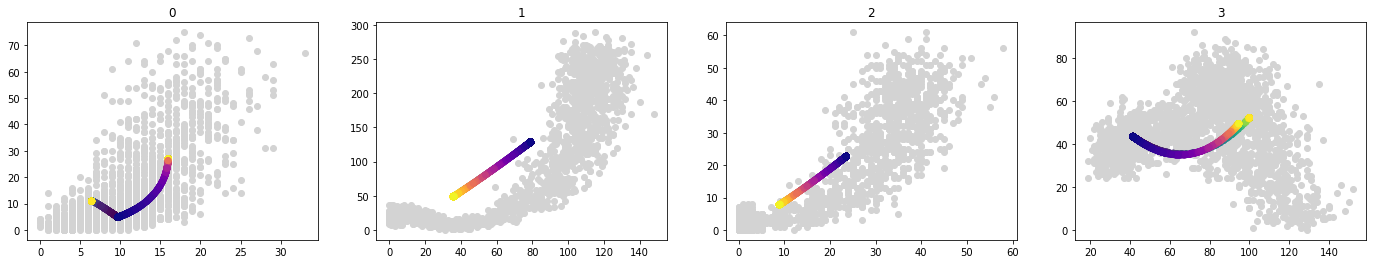

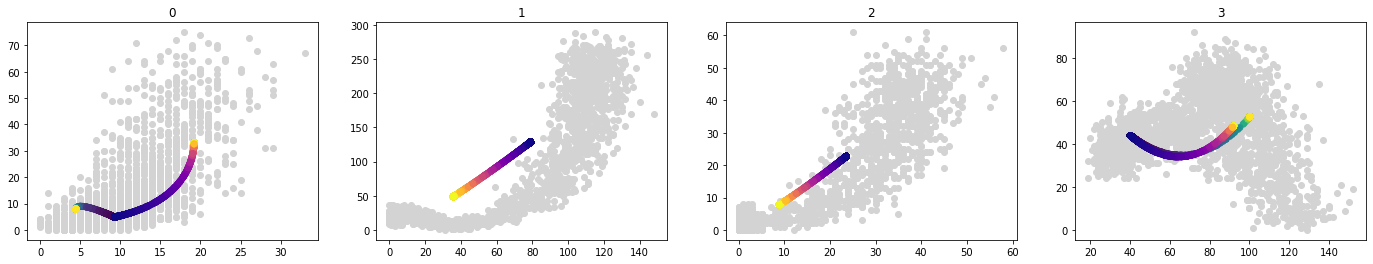

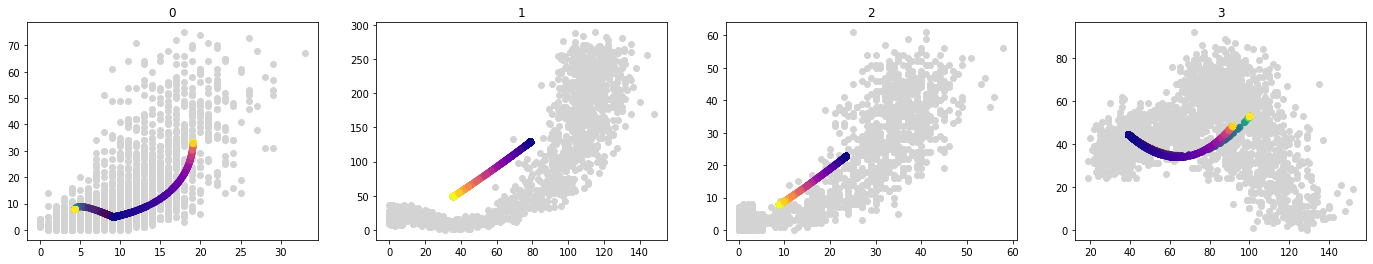

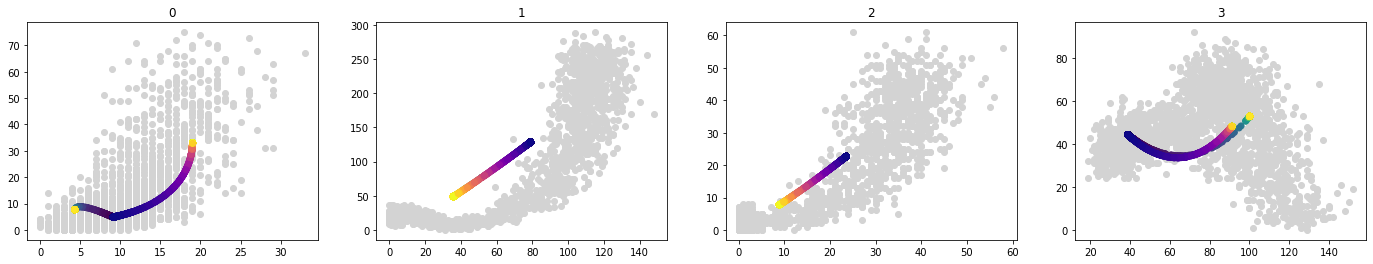

In [354]:
traj = TI_model(topo,tau)
thetas, weights, elbos = traj.fit(X, Q0, epoch=10, parallel=True, n_threads=4)

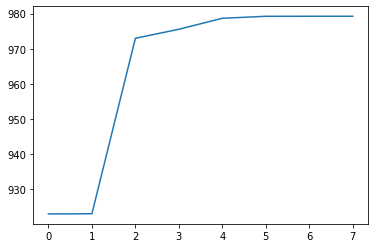

In [363]:
plt.plot(elbos)

In [356]:
traj.converged

True

100%|██████████| 3/3 [01:08<00:00, 22.96s/it]


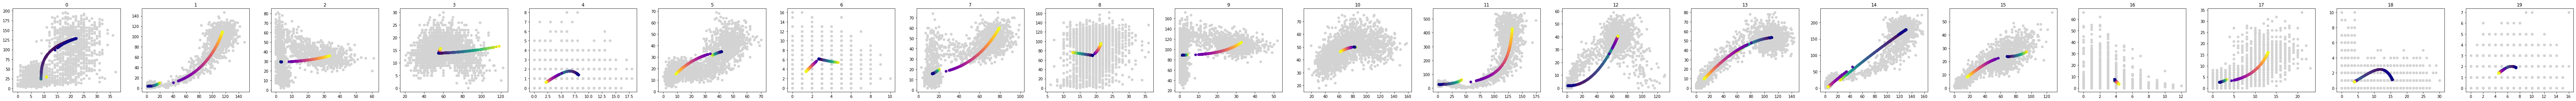

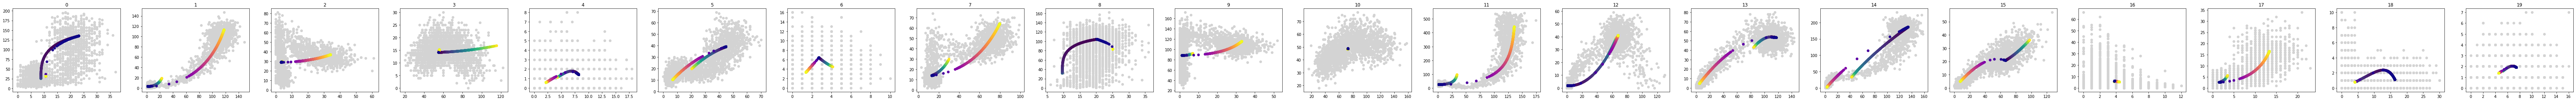

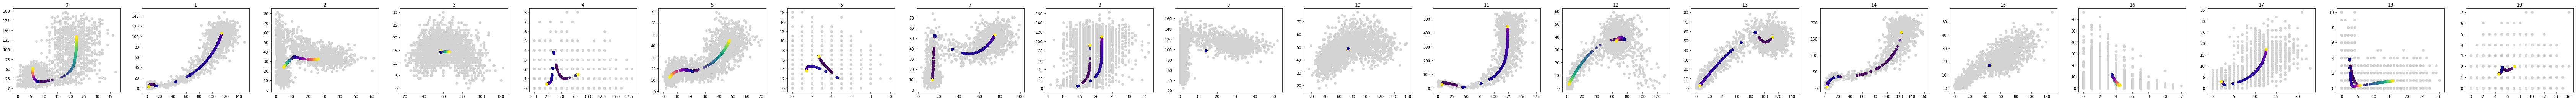

In [18]:
traj = TI_model(topo,tau)
traj.fit_(X, 100, epoch=20, parallel=True, n_threads=4)

In [16]:
Q, elbo = traj.update_weight(X)

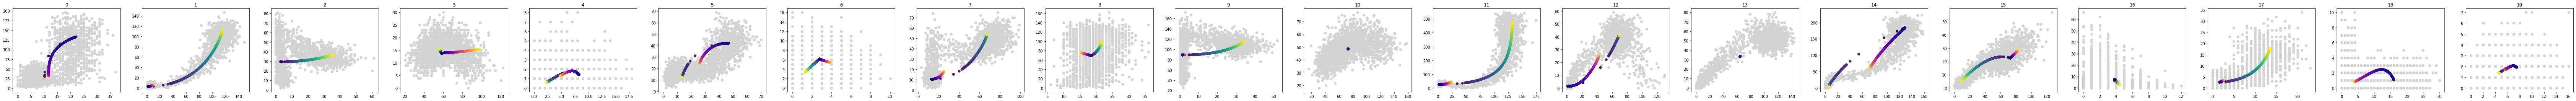

In [17]:
plot_phase(X,traj.theta,Q,topo,tau)

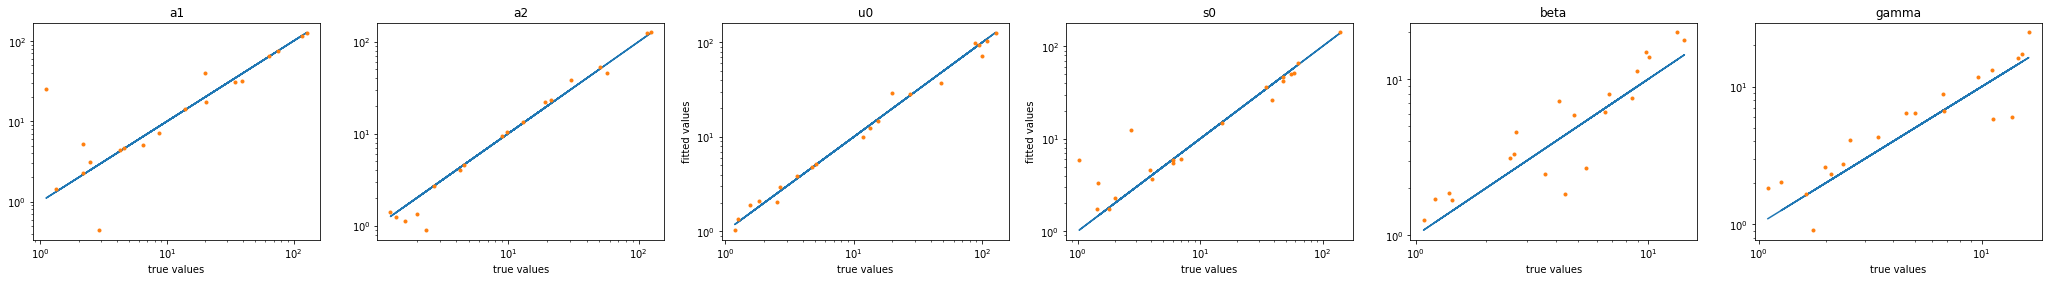

In [381]:
plot_theta(true_theta[:,],traj.theta)

CPU times: user 99.5 ms, sys: 181 ms, total: 280 ms
Wall time: 1min 3s


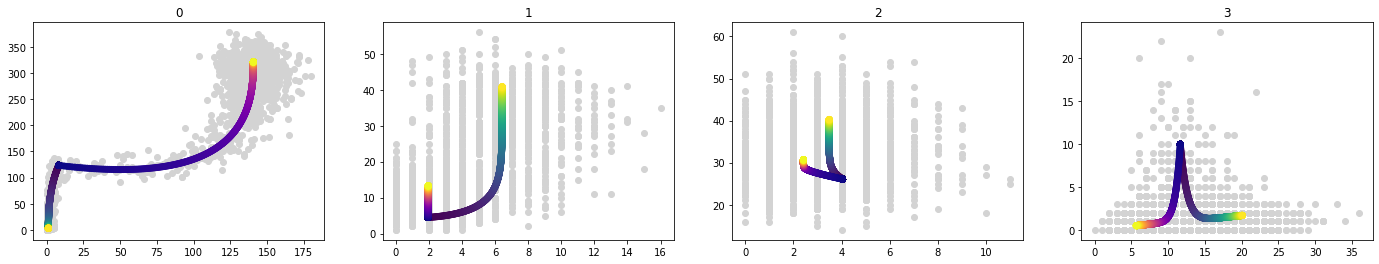

In [35]:
#%% update theta
%time theta_hat = update_theta(X,Q,theta_G,penalty=n*0.001,parallel=True,n_threads=4)
plot_phase(X,theta_hat,Q,theta_G)

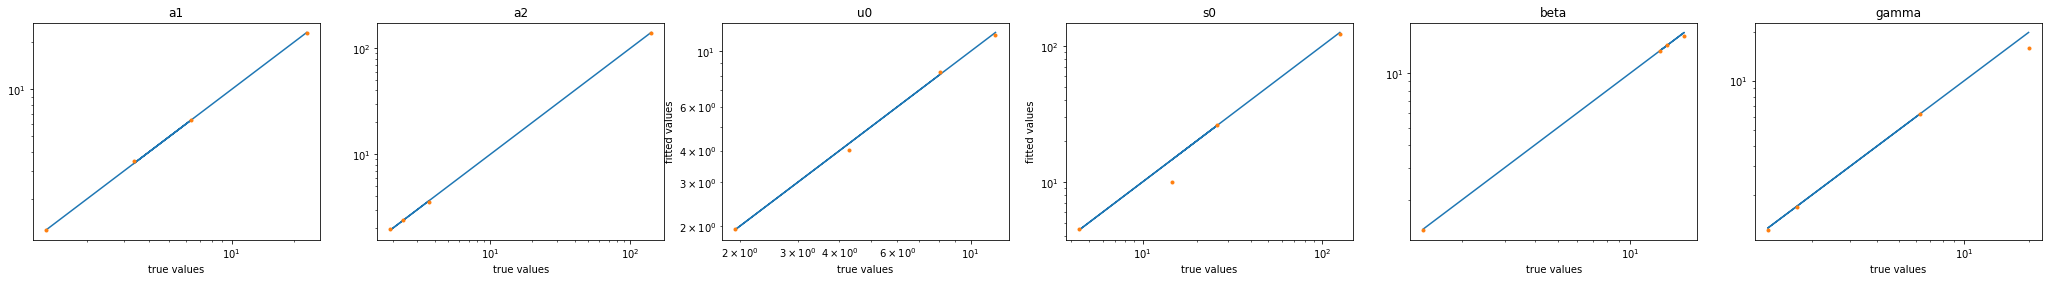

In [36]:
plot_theta(theta[:,],theta_hat)

Thu Jul 21 14:08:49 PDT 2022
CPU times: user 249 ms, sys: 113 ms, total: 363 ms
Wall time: 4min 23s


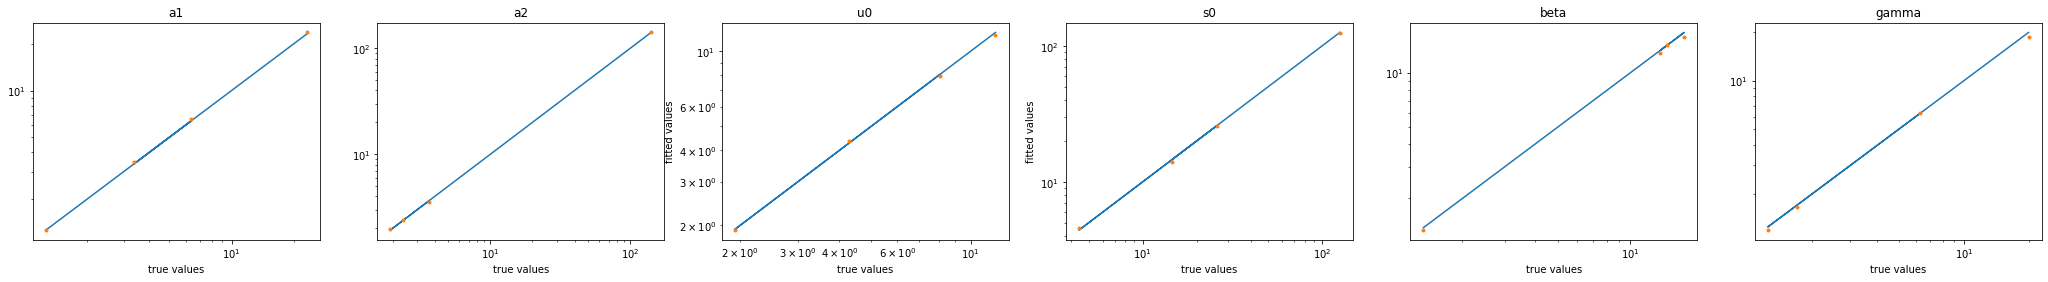

In [215]:
%time theta_hat=update_theta(X,Q,theta_G,alternative=True, parallel=True,n_threads=min(4,p),theta0=None)
plot_theta(theta[:,],theta_hat)

## Given uninformative time, estimation is terrible

In [37]:
m=int(n/10)
weight=np.ones((n,1,m))
weight=weight/weight.sum(axis=(1,2),keepdims=True)

In [13]:
beta0=1
theta0 = beta0*np.ones((p,K+4))
theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]/beta0
theta0[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)*beta0

In [18]:
%time theta_hat=update_theta(X,weight,tau,penalty=0,parallel=True,n_threads=min(4,p),theta0=theta0)

CPU times: user 15.9 ms, sys: 149 ms, total: 165 ms
Wall time: 3.04 s


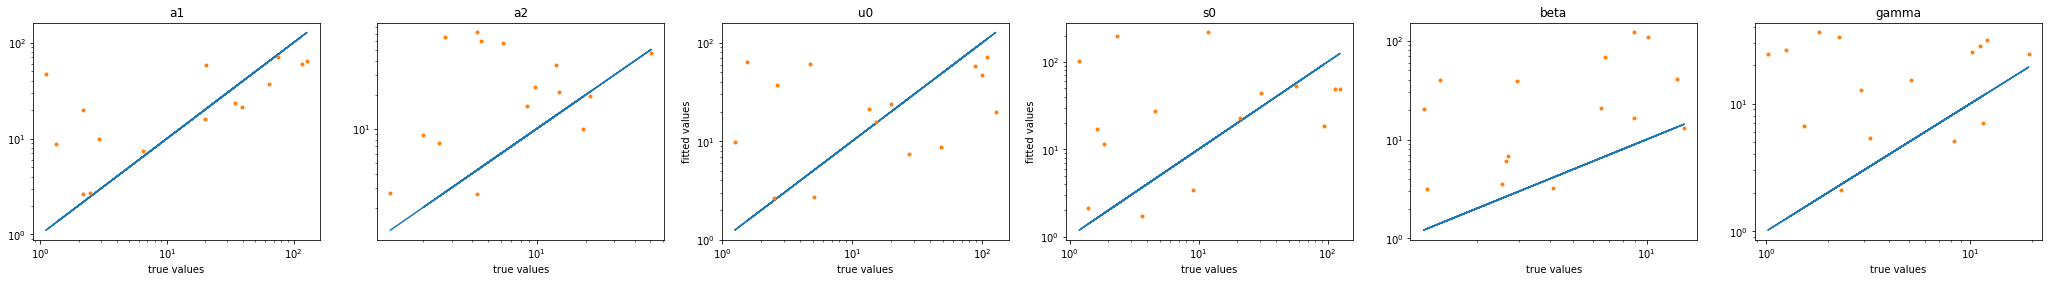

In [19]:
plot_theta(theta,theta_hat)

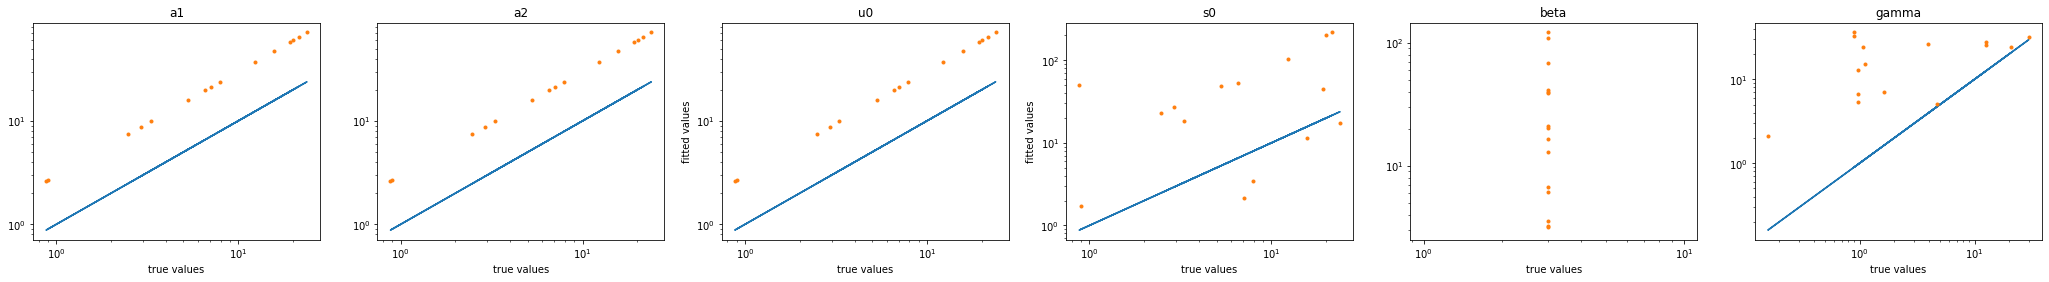

In [20]:
plot_theta(theta0,theta_hat)

In [25]:
%time theta_hat_a=update_theta(X,weight,tau,penalty=0,alternative=True, parallel=True,n_threads=min(40,p),theta0=theta0)

CPU times: user 31.7 ms, sys: 137 ms, total: 169 ms
Wall time: 16 s


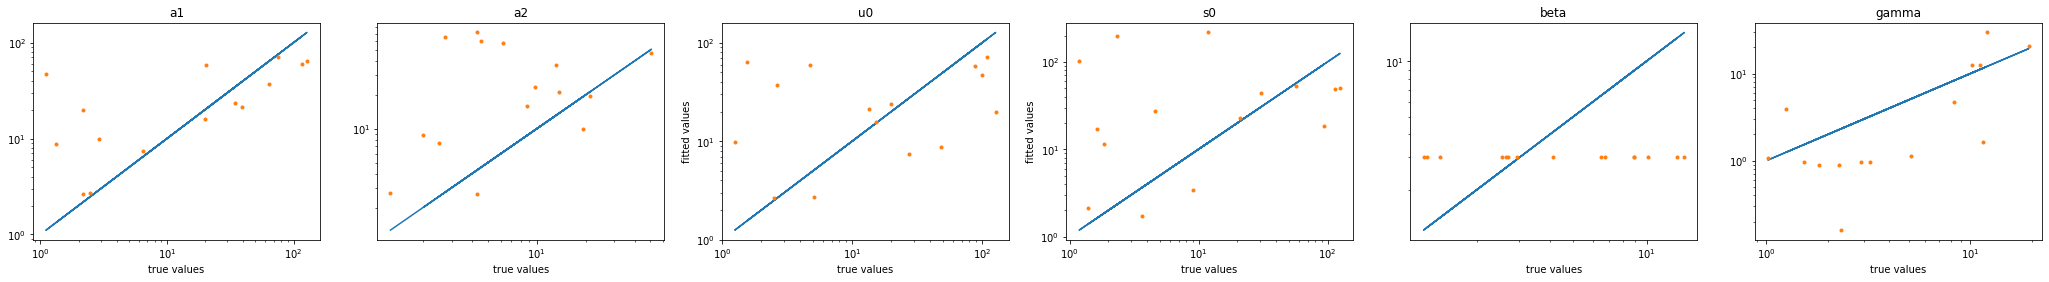

In [26]:
plot_theta(theta,theta_hat_a)

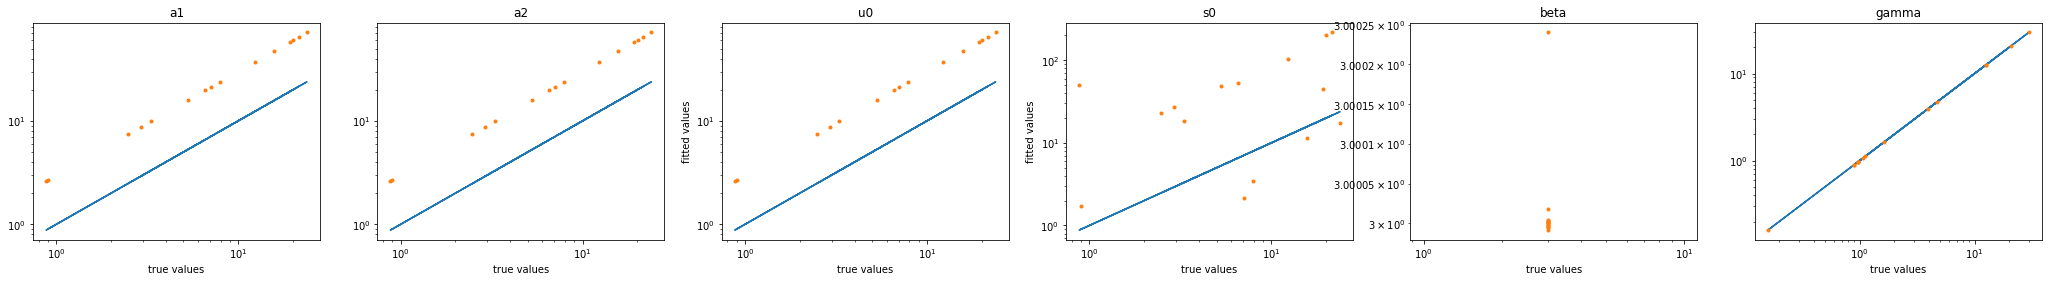

In [27]:
plot_theta(theta0,theta_hat_a)

In [28]:
weight = update_weight(X,theta_hat,tau,m)

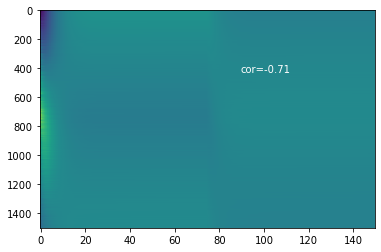

In [29]:
plot_t(weight, ax=None, t=t)

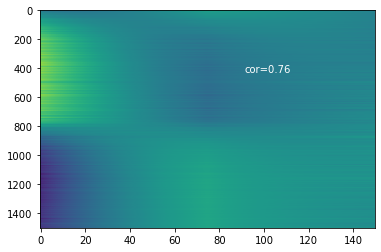

In [30]:
weight = update_weight(X,theta_hat_a,tau,m)
plot_t(weight, ax=None, t=t)

### Therefor, a warm start is necessary!

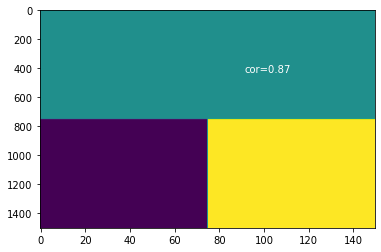

In [7]:
m=int(n/10)
weight0=np.ones((n,m))
weight0[int(n/2):,int(m/2):] += 0.1
weight0 = weight0/weight0.sum(axis=1,keepdims=True)
plot_t(weight0, ax=None, t=t)

In [35]:
%time theta_hat=update_theta(X,weight,tau,penalty=0,parallel=True,n_threads=min(40,p),theta0=theta0)

CPU times: user 42.7 ms, sys: 121 ms, total: 164 ms
Wall time: 2.85 s


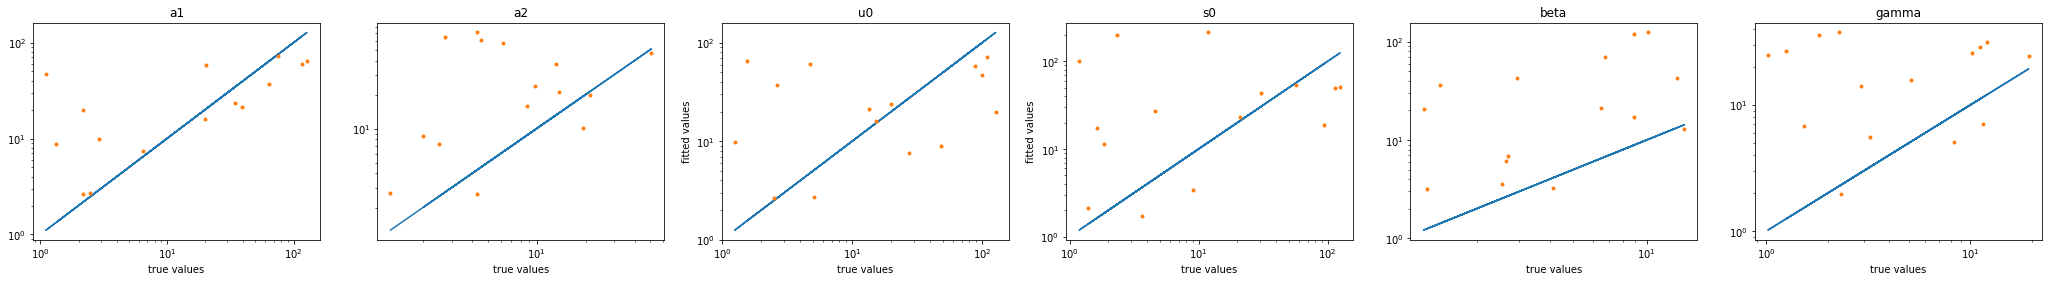

In [36]:
plot_theta(theta,theta_hat)

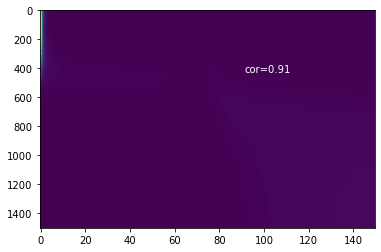

In [37]:
weight = update_weight(X,theta_hat,tau,m)
plot_t(weight, ax=None, t=t)

## traj_EM

### Close look at one example

In [125]:
#%% generate data
np.random.seed(42)
n = 2000
m = 1000
p = 20

tau=(0,0.5,1)
topo = np.array([[0,1],[0,2]])
n_states=len(set(topo.flatten()))
theta_G={"tau":tau,"topo":topo}

if n_states < len(tau)-1:
    print("check tau and topo")
t = np.linspace(0, 1, m)

theta=np.zeros((p,n_states+4))
for k in range(n_states+2):
    theta[:,k]=np.exp(np.random.uniform(0,5,size=p))
    
theta[:,-2]=np.exp(np.random.uniform(0,3,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,3,size=p))

Y = np.zeros((n,p,2))
for l in range(len(topo)):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
    Y[l*m:(l+1)*m] = get_Y(theta_l,t,tau) # m*p*2
    
X = np.random.poisson(Y)

In [126]:
weight0=np.ones((n,2,m))
weight0=weight0/weight0.sum(axis=(1,2),keepdims=True)

In [127]:
theta_hat_hist, weight_hist = traj_EM(X, theta_G, weight0, epoch=10, parallel = True, n_threads = min(20,p))

100%|██████████| 10/10 [12:57<00:00, 77.77s/it]


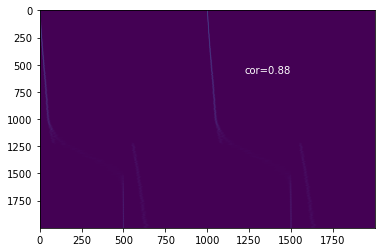

In [129]:
plot_t(weight_hist[-1], ax=None, t=np.append(t,t))

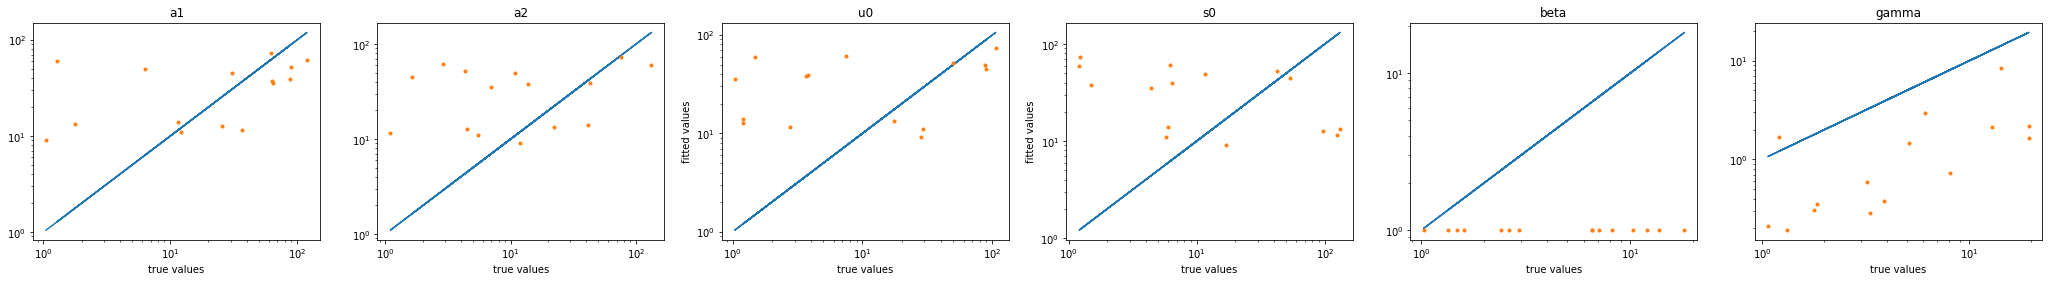

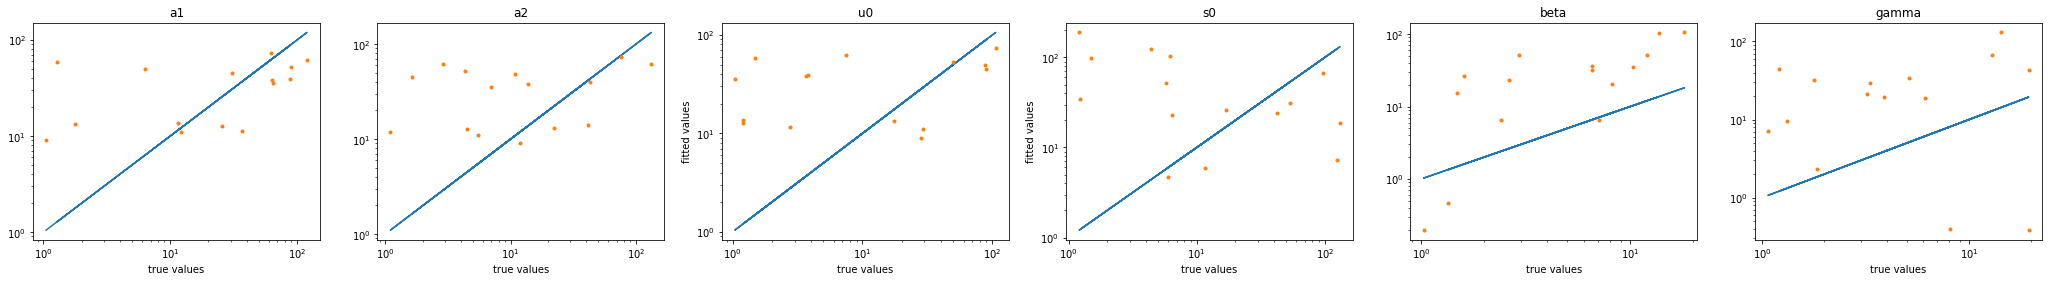

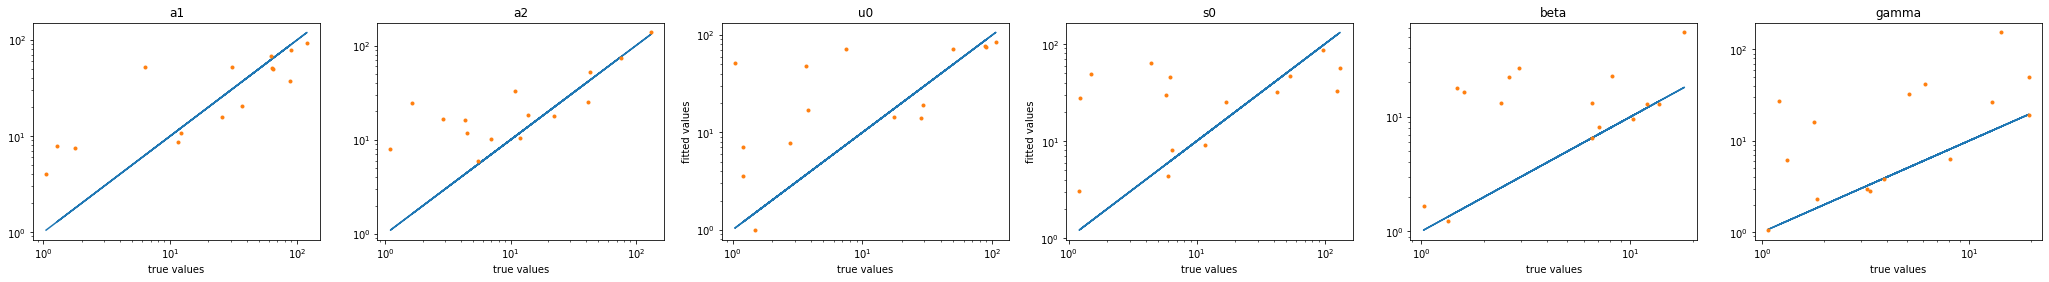

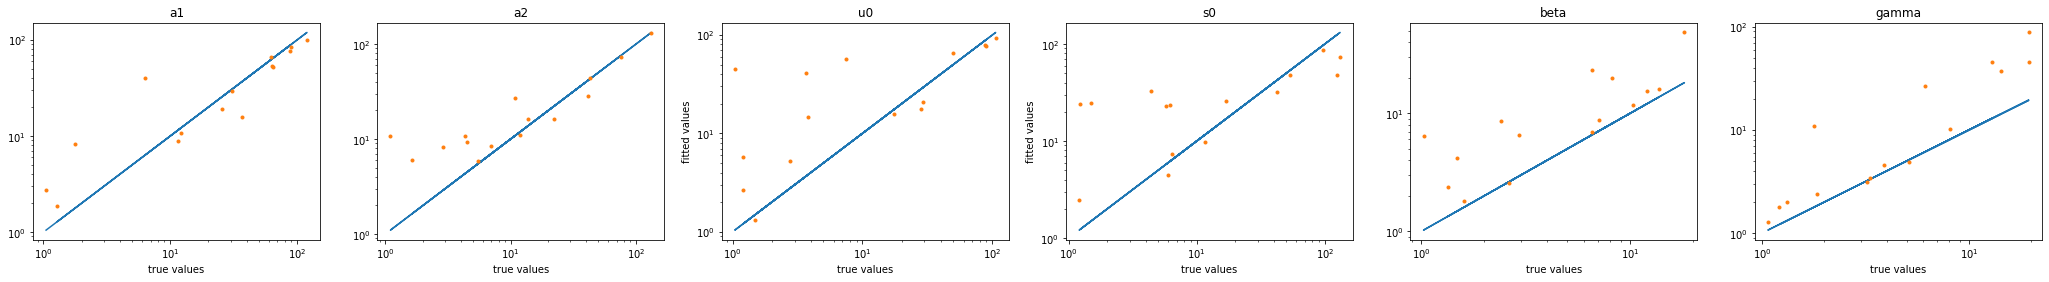

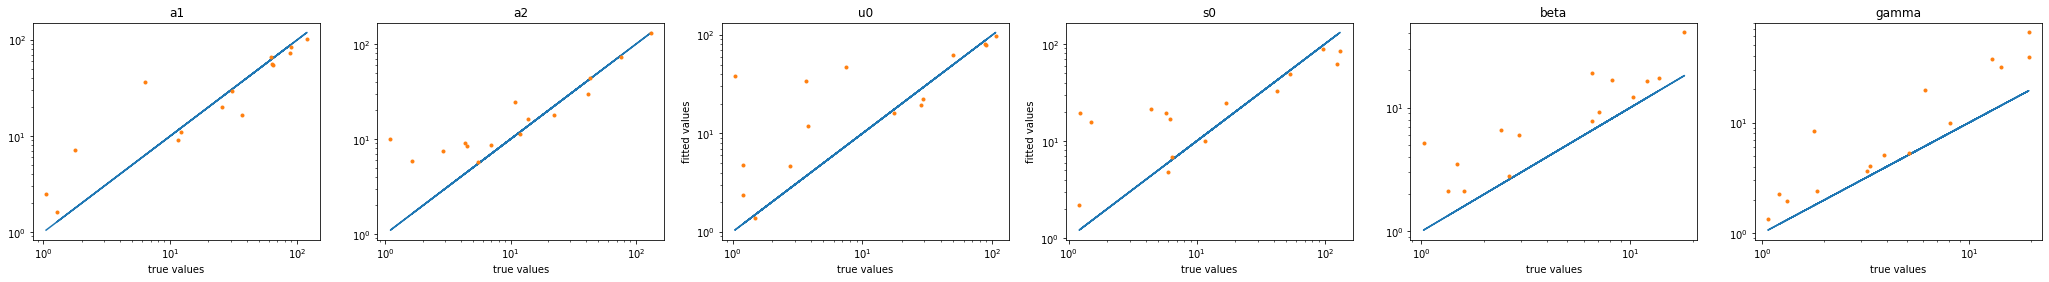

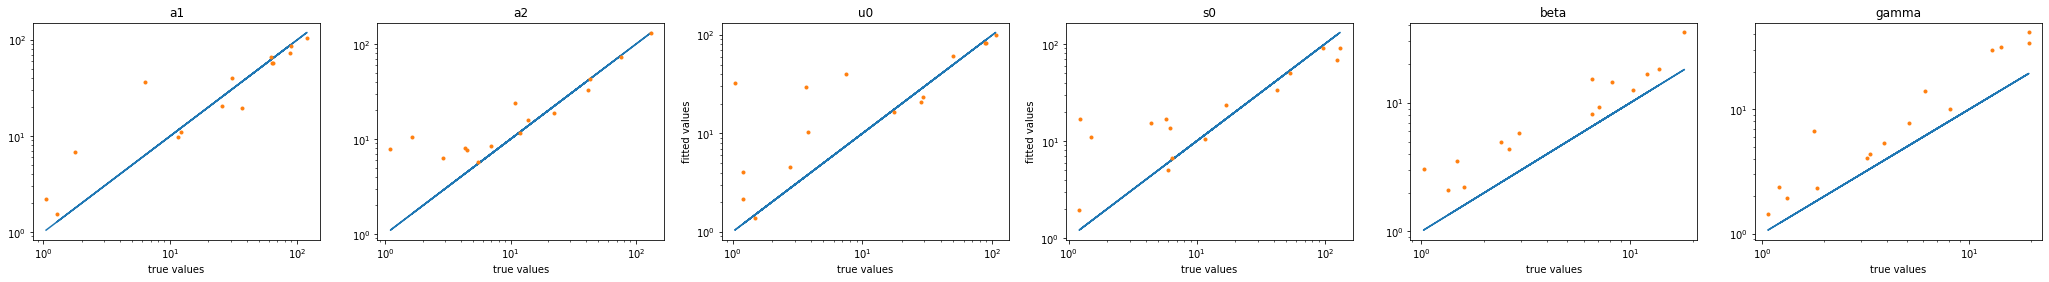

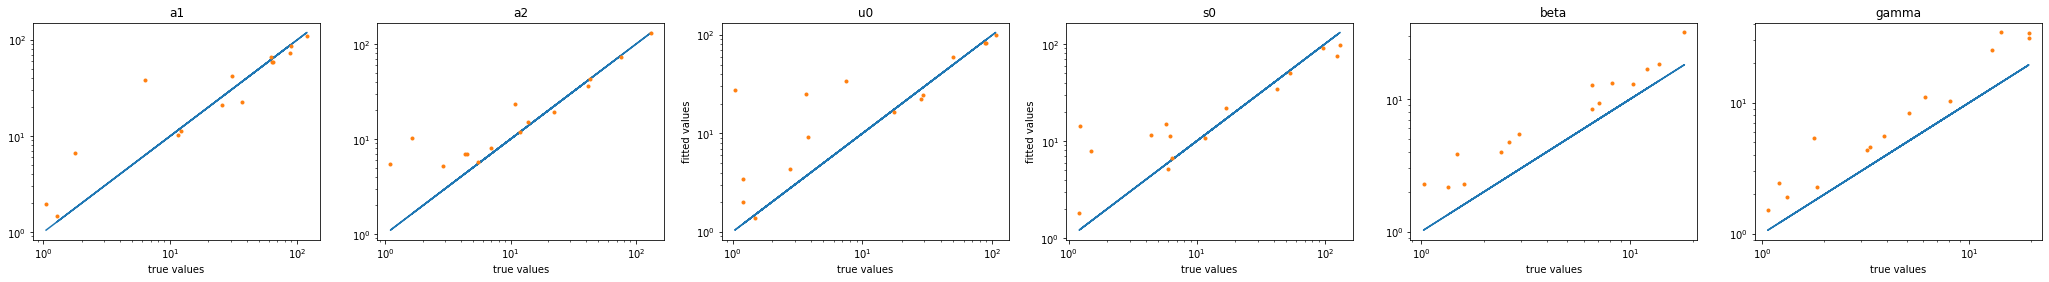

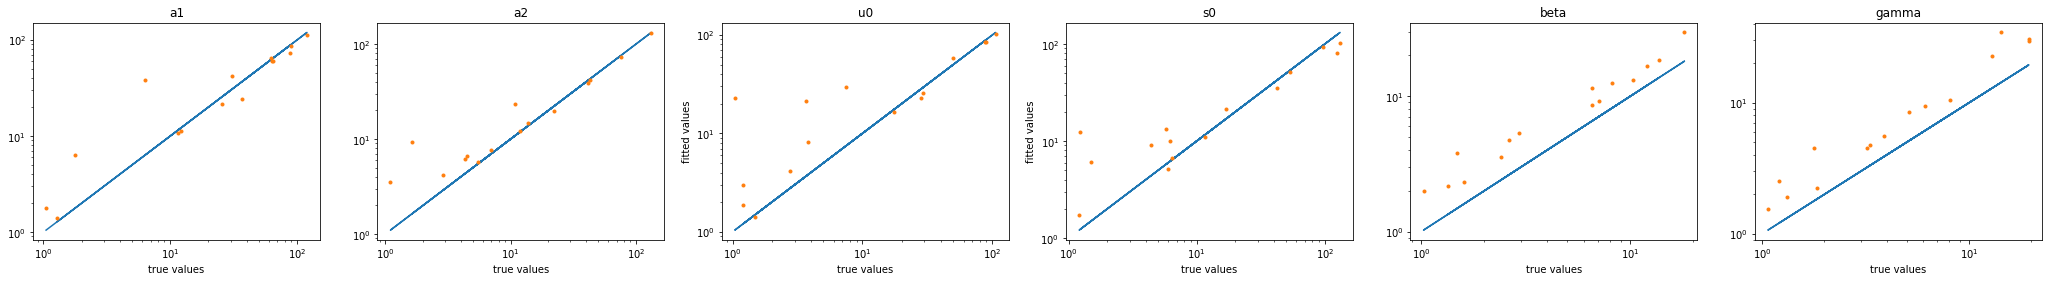

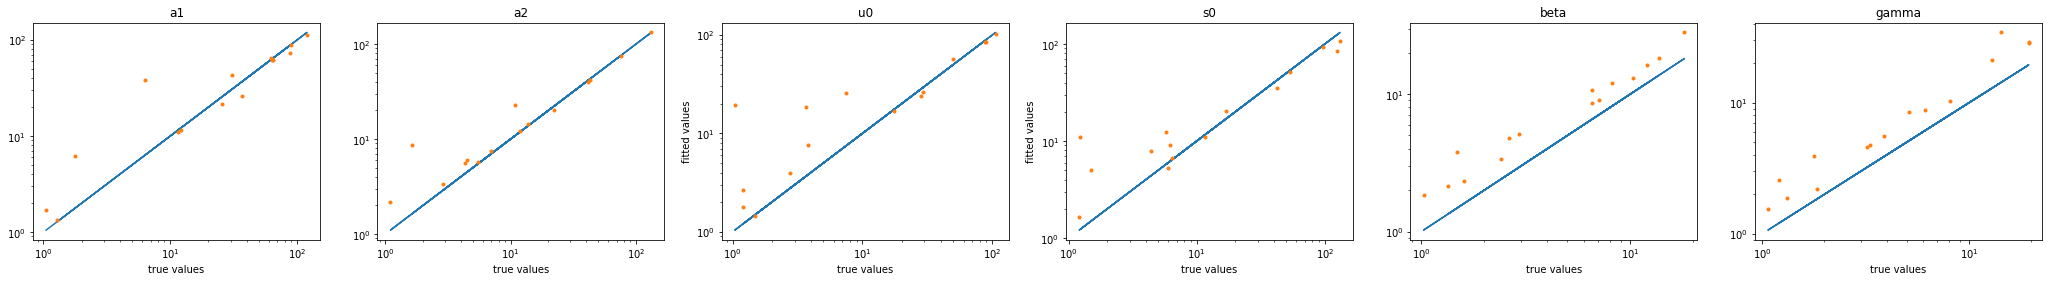

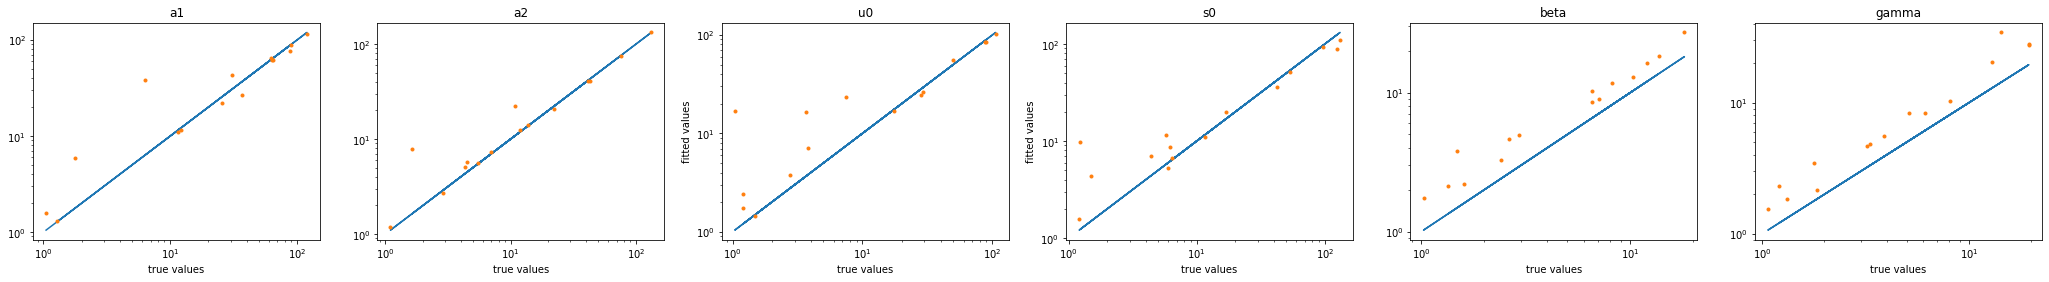

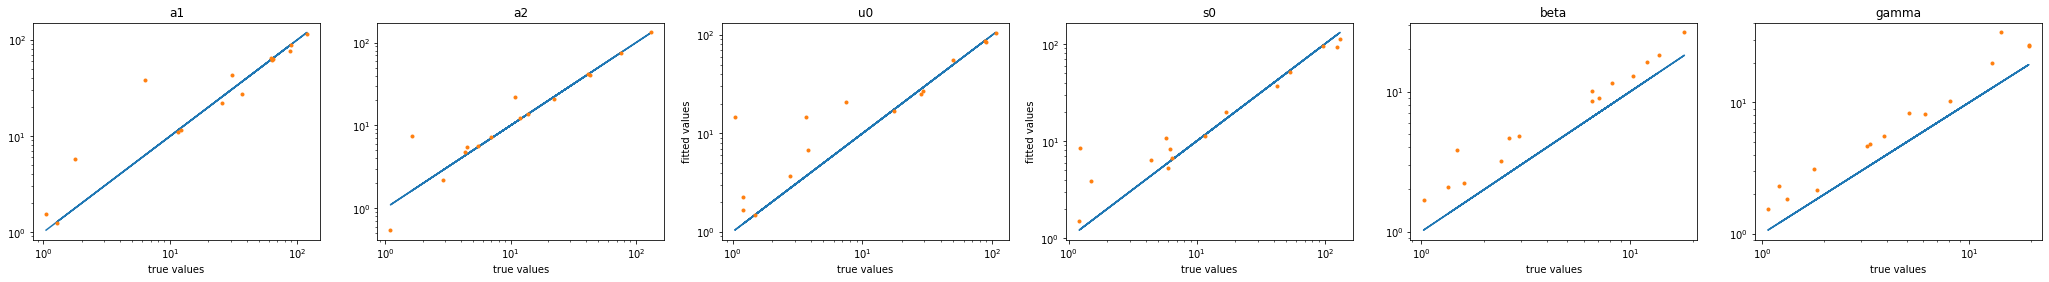

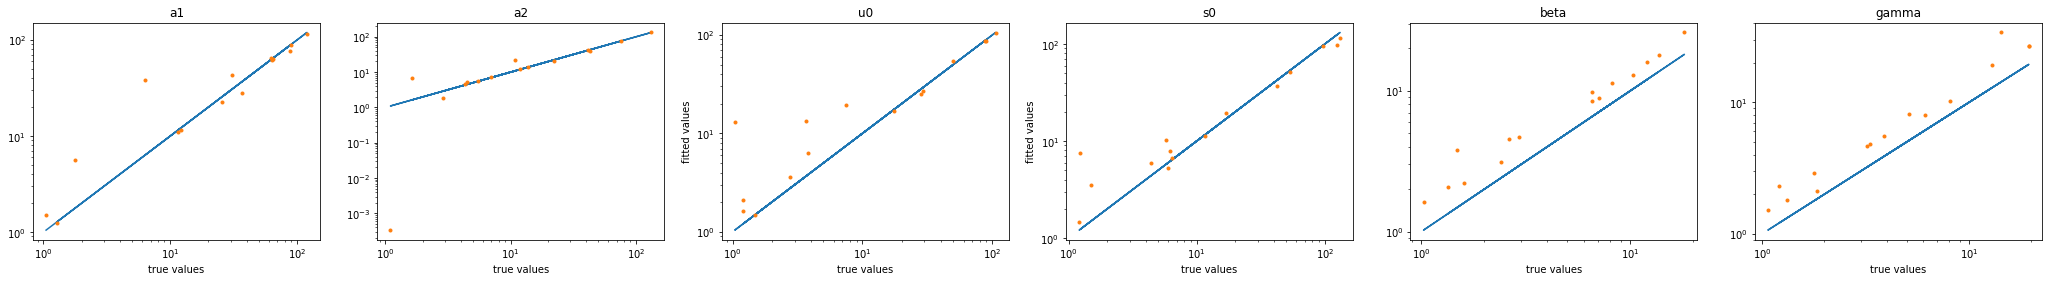

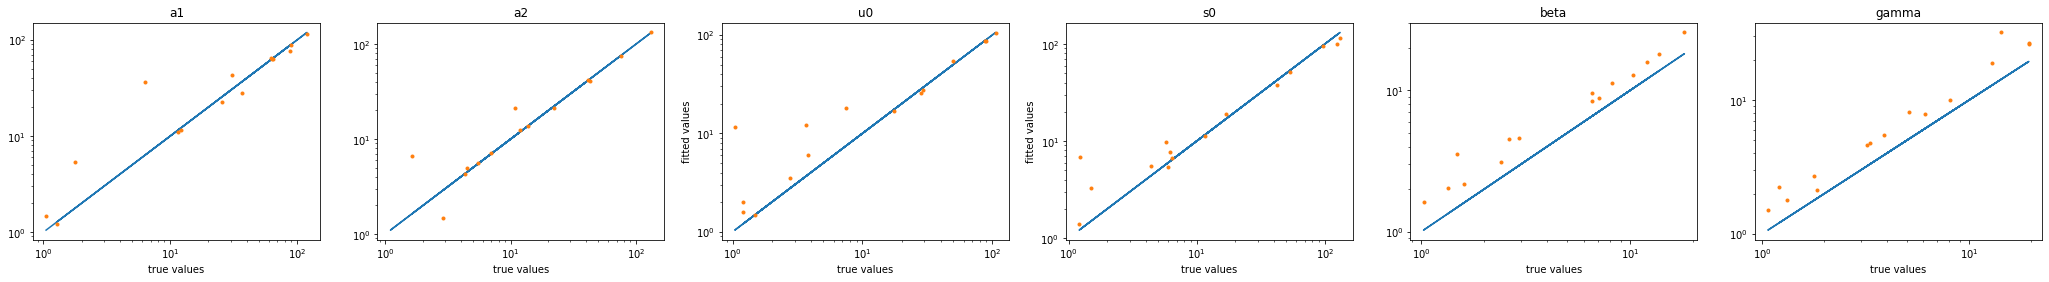

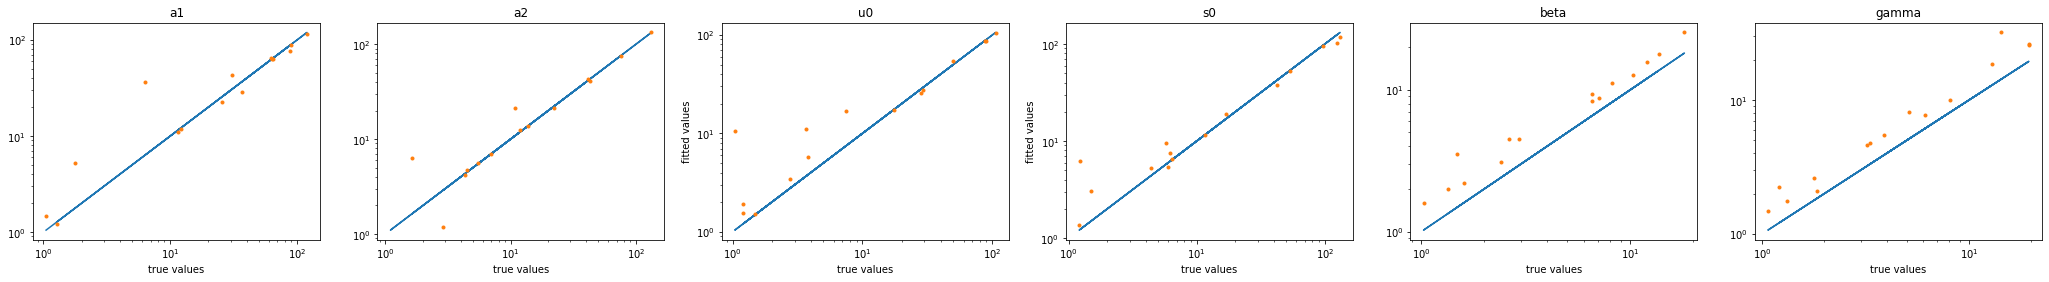

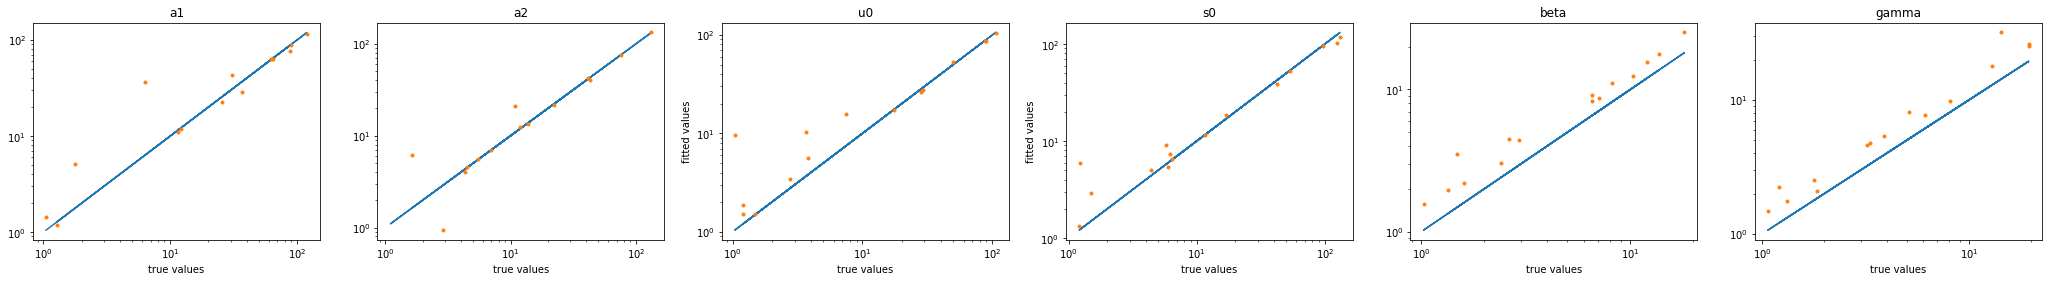

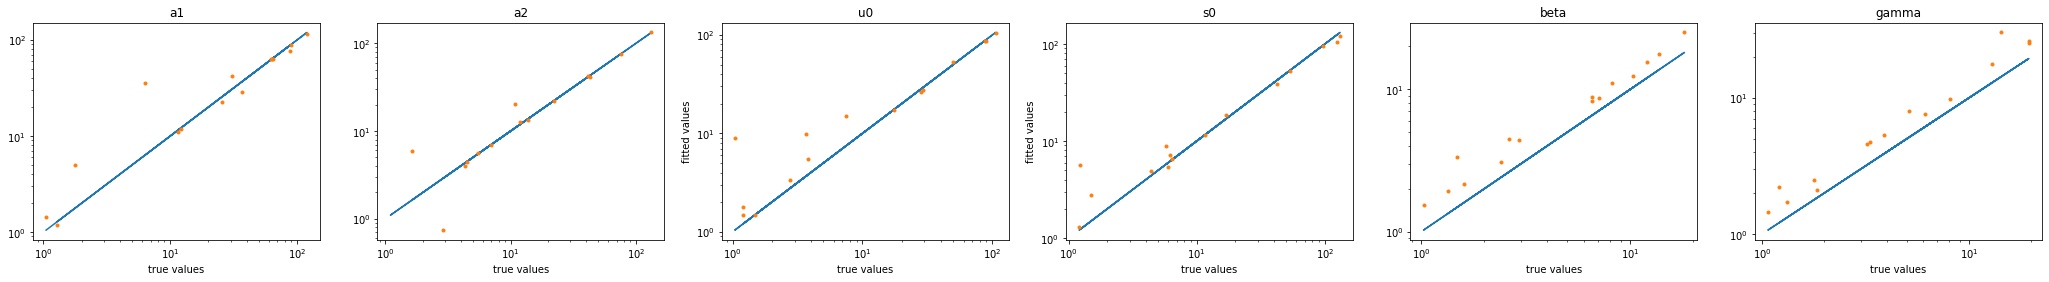

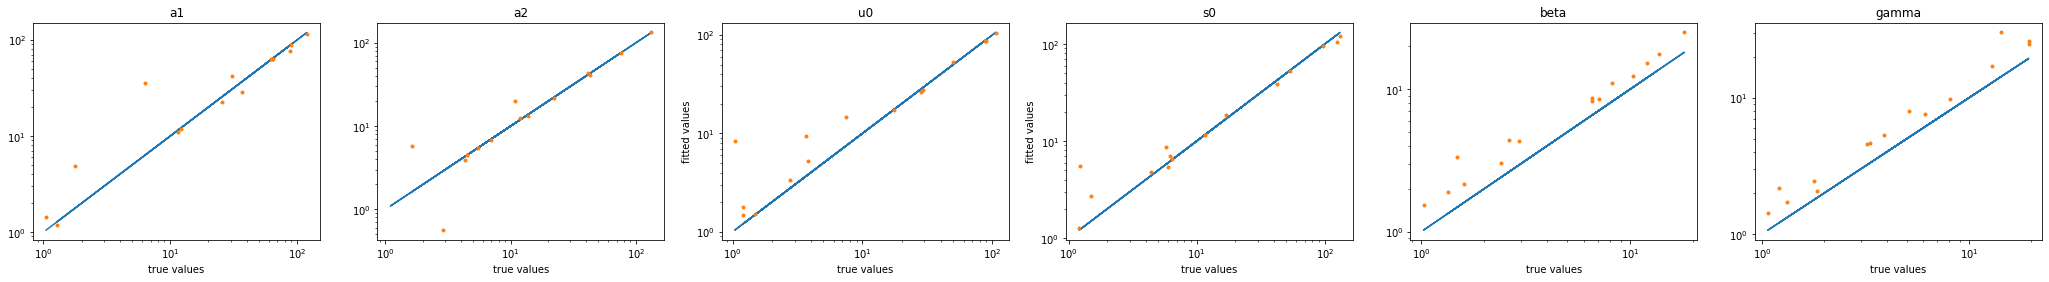

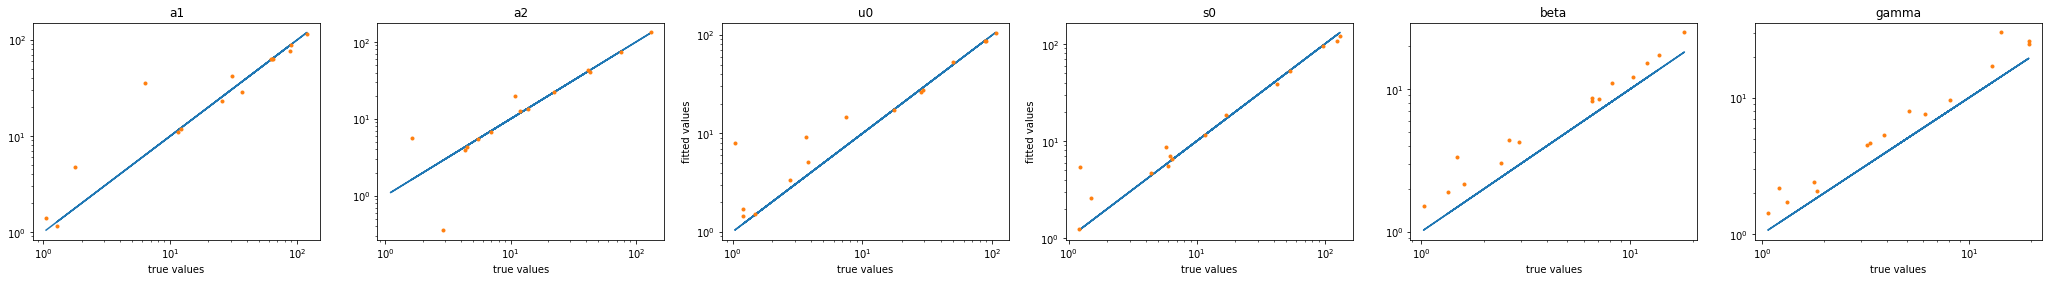

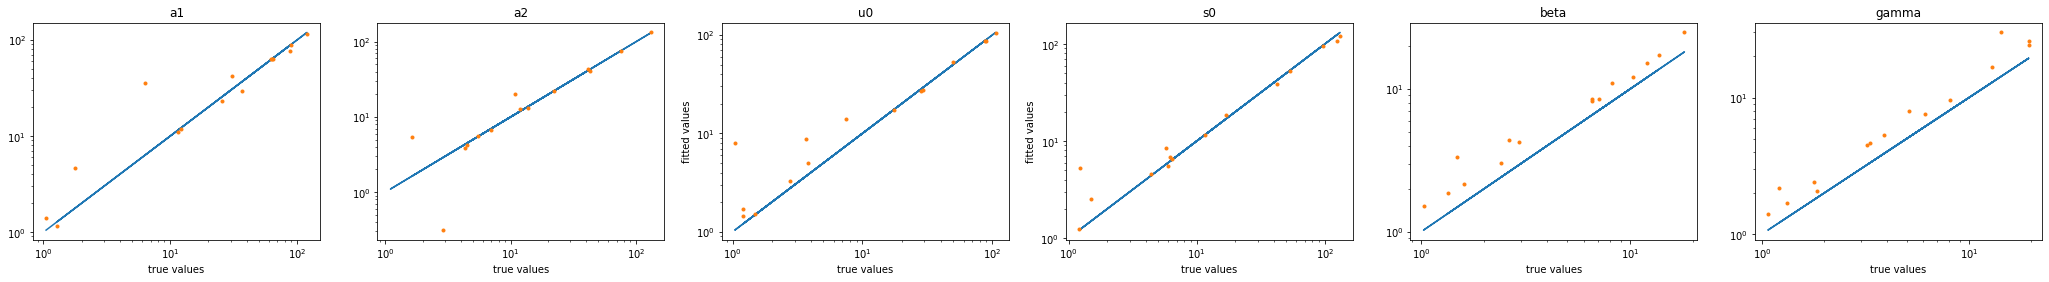

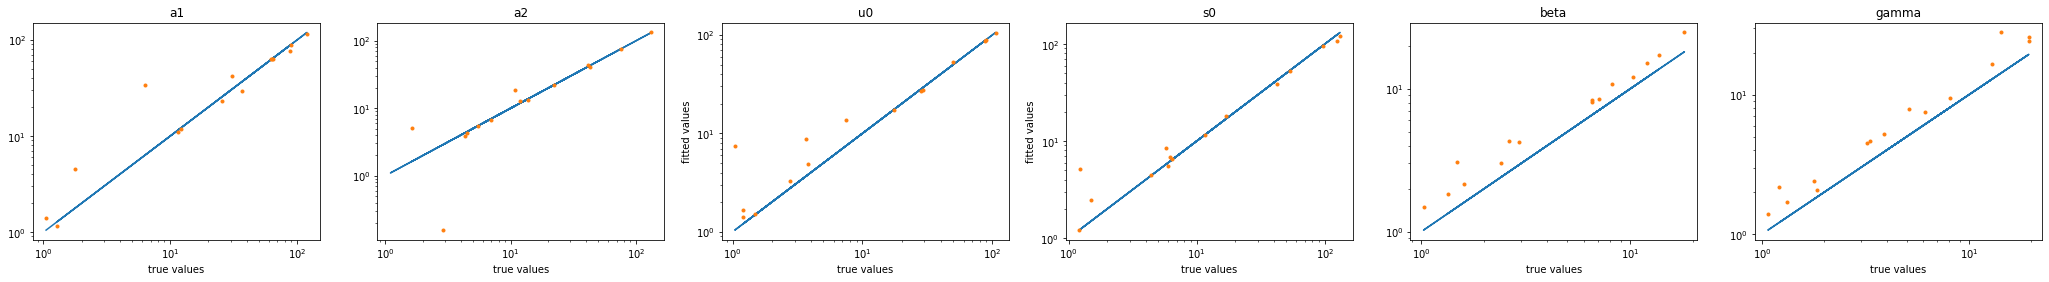

In [41]:
for i in range(20):
    plot_theta(theta,theta_hat_hist[i])

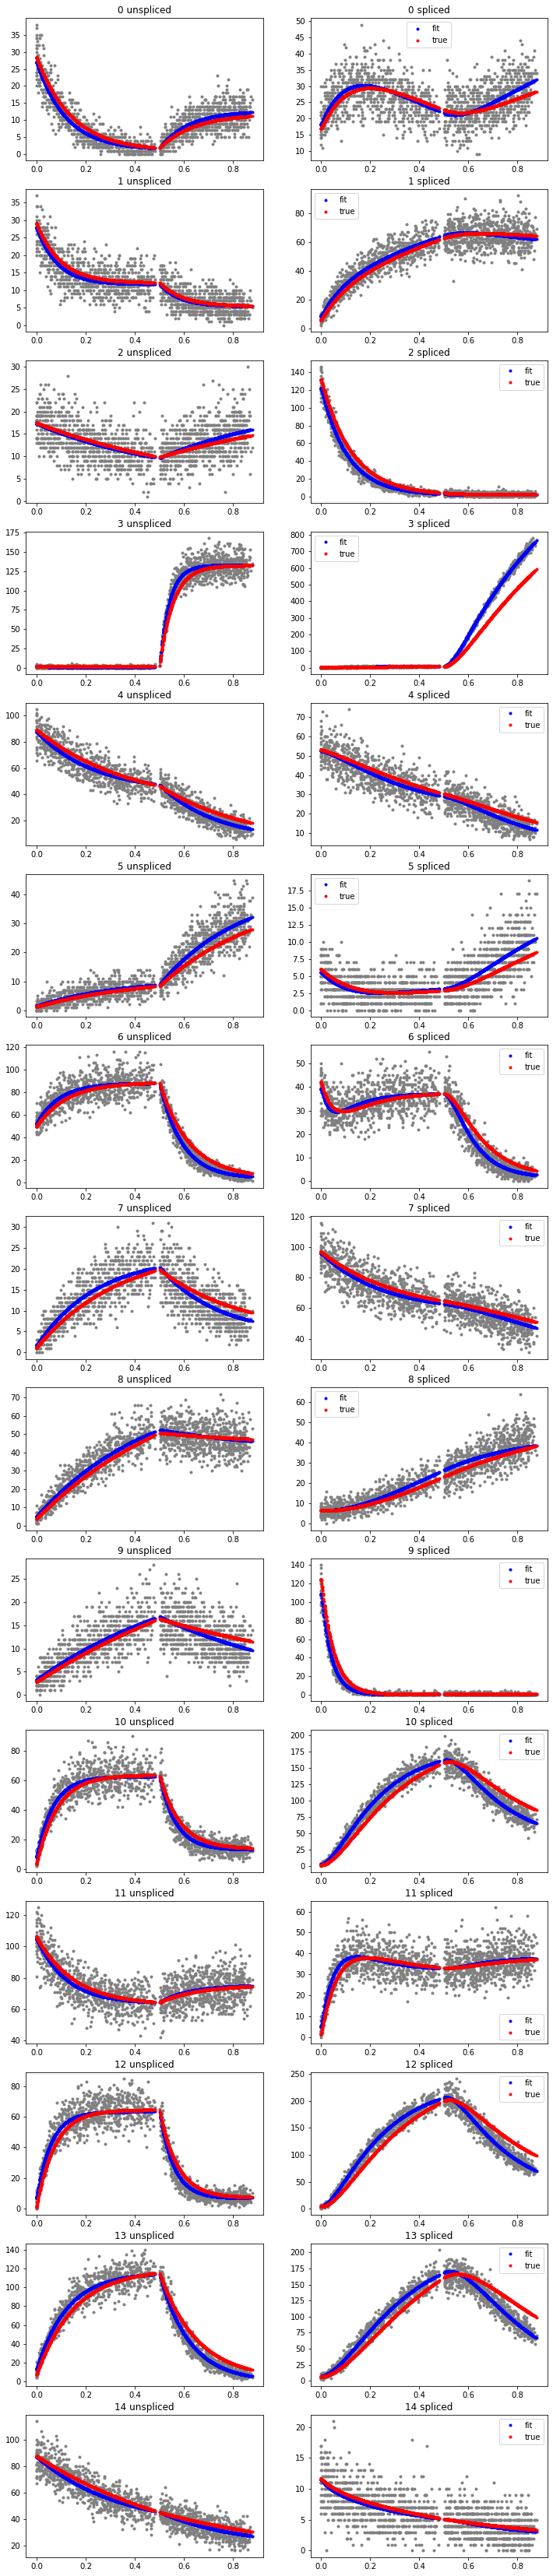

In [43]:
plot_y(theta,theta_hat_hist[-1],weight_hist[-1],tau,[str(i) for i in range(20)])

# Test

An informative gene should have moderate beta and gamma value, not too small so that there are dynamics, and also not too large so that the dynamics are a significant part of data.

In [43]:
def get_fit_result(n, rs=[0.01, 1/30, 0.1], warm=True, add_null=False, true_tau=None, relative_penalty=0, loga_max=4, logb_max=2, seeds=[21, 42, 63, 84], cores=20):
    tau=(0,0.5,1)
    if true_tau is None:
        true_tau = tau
    K=len(tau)-1
    t = np.linspace(0, 1, n)

    m=int(n/10)
    weight0=np.ones((n,m))
    if warm:
        weight0[int(n/2):,int(m/2):] += 0.1
    weight0 = weight0/weight0.sum(axis=1,keepdims=True)
    
    #fig, axs = plt.subplots(len(rs), K+4+len(seeds), figsize=(6*(K+4+len(seeds)),4*len(rs)))
    thetas=[]
    theta_hats=[]
    weights=[]
    
    for i,r in enumerate(rs): 
        true_p = int(n*r)  
        if add_null:
            p = 2*true_p
        else:
            p = true_p

        for j,seed in enumerate(seeds):
            np.random.seed(seed)
            theta=np.zeros((p,K+4))
            theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[true_p:,-2]=1
            theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
            theta[true_p:,0]=theta[true_p:,-4]
            theta[true_p:,1]=theta[true_p:,-4]
            theta[true_p:,-3]=theta[true_p:,-4]/theta[true_p:,-3]
            thetas.append(theta)
            
            Y = get_Y(theta,t,true_tau)
            X = np.random.poisson(Y)

            theta_hat_hist, weight_hist = traj_EM(X, tau, weight0, relative_penalty=relative_penalty, epoch=20, parallel = True, n_threads = min(cores,p))
            theta_hat = theta_hat_hist[-1]
            theta_hats.append(theta_hat)
            weight=weight_hist[-1]
            weights.append(weight)
    
    return thetas, theta_hats, weights


def plot_fit_result(n, rs=[0.01, 1/30, 0.1], warm=True, add_null=False, true_tau=None, relative_penalty=0, loga_max=4, logb_max=2, seeds=[21, 42, 63, 84], cores=20):
    tau=(0,0.5,1)
    if true_tau is None:
        true_tau = tau
    K=len(tau)-1
    t = np.linspace(0, 1, n)

    m=int(n/10)
    weight0=np.ones((n,m))
    if warm:
        weight0[int(n/2):,int(m/2):] += 0.1
    weight0 = weight0/weight0.sum(axis=1,keepdims=True)
    
    fig, axs = plt.subplots(len(rs), K+4+len(seeds), figsize=(6*(K+4+len(seeds)),4*len(rs)))
    thetas=[]
    theta_hats=[]
    weights=[]
    
    for i,r in enumerate(rs): 
        true_p = int(n*r)  
        if add_null:
            p = 2*true_p
        else:
            p = true_p

        for j,seed in enumerate(seeds):
            np.random.seed(seed)
            theta=np.zeros((p,K+4))
            theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[true_p:,-2]=1
            theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
            theta[true_p:,0]=theta[true_p:,-4]
            theta[true_p:,1]=theta[true_p:,-4]
            theta[true_p:,-3]=theta[true_p:,-4]/theta[true_p:,-3]
            thetas.append(theta)
            
            Y = get_Y(theta,t,true_tau)
            X = np.random.poisson(Y)

            theta_hat_hist, weight_hist = traj_EM(X, tau, weight0, relative_penalty=relative_penalty, epoch=20, parallel = True, n_threads = min(cores,p))
            theta_hat = theta_hat_hist[-1]
            theta_hats.append(theta_hat)
            weight=weight_hist[-1]
            weights.append(weight)
            
            for k in range(K+4):
                axs[i,k].loglog(theta[:,k],theta_hat[:,k],'.')
                axs[i,k].loglog(theta[:,k],theta[:,k],'k')
    
            plot_t(weight, ax=axs[i,K+4+j], t=t)
        
    return


## Warm start and different n

100%|██████████| 20/20 [05:44<00:00, 17.25s/it]


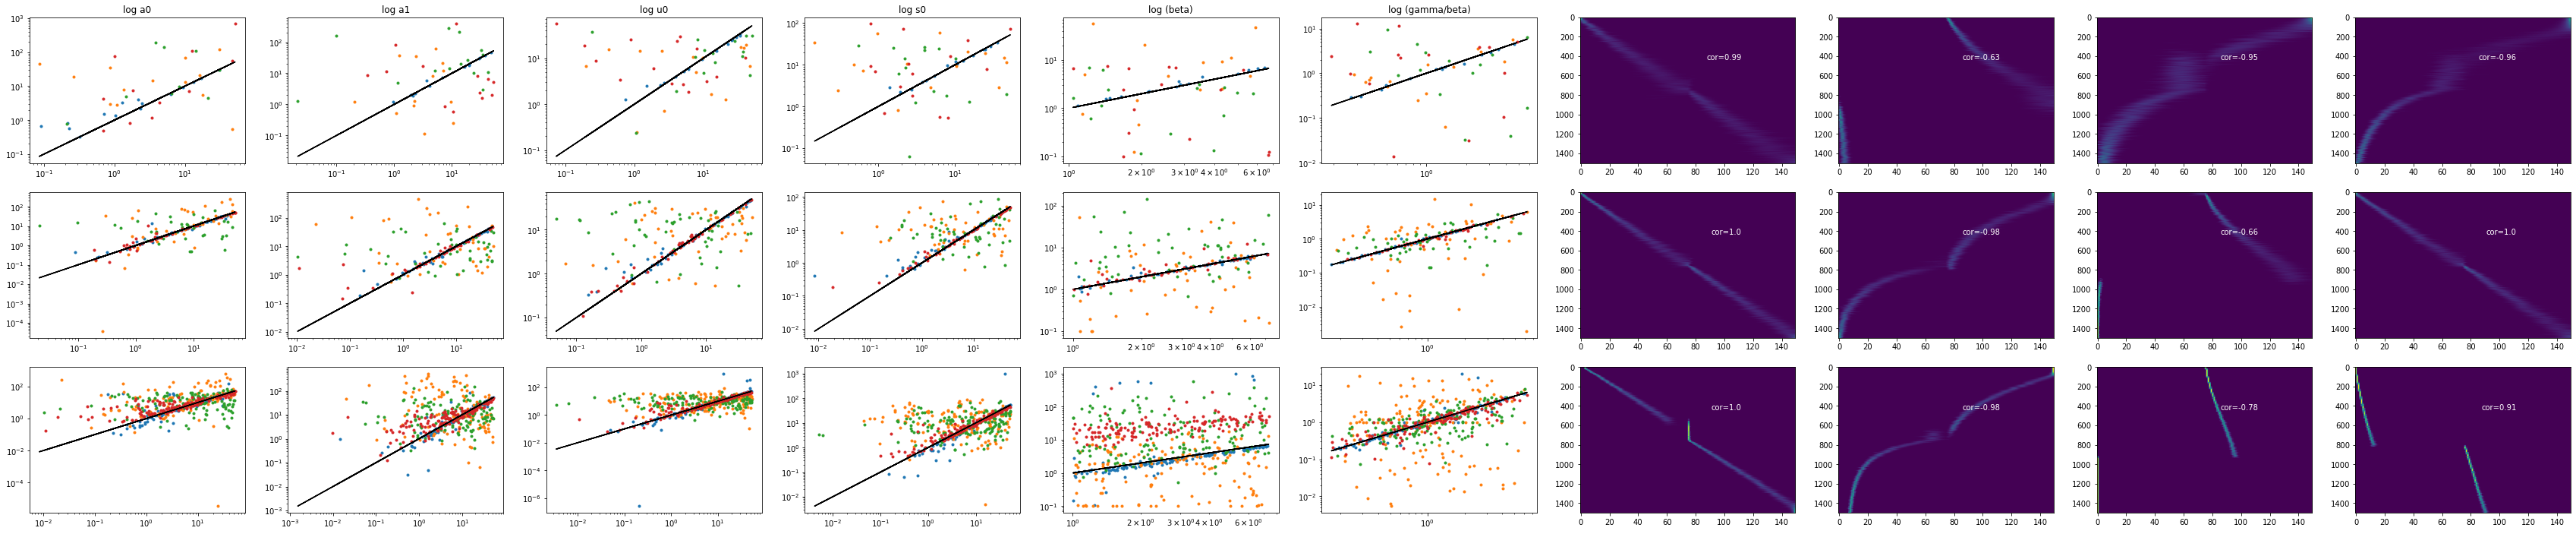

In [78]:
plot_fit_result(1500, warm=False) 

In [ ]:
plot_fit_result(1500, cores=40)

In [ ]:
plot_fit_result(3000, cores=40)

## Including some uninformative genes

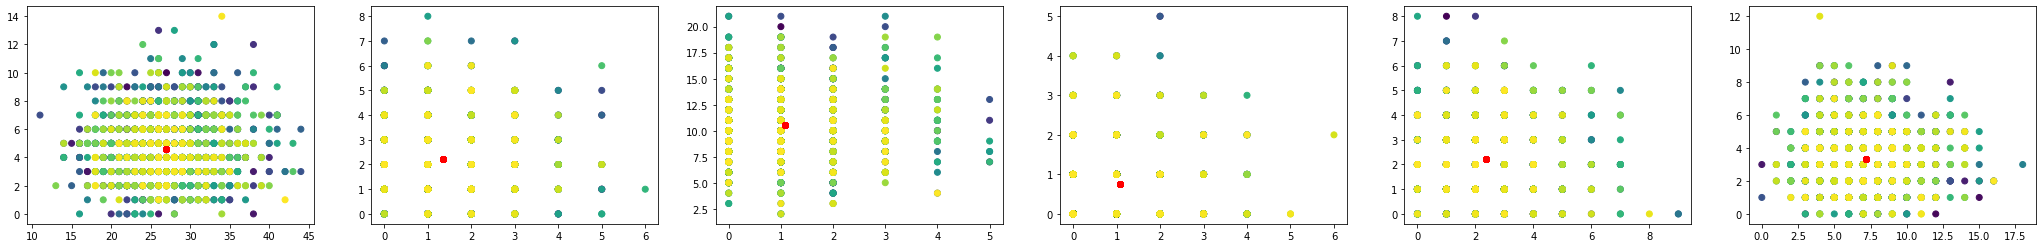

In [15]:
n=1500
t=np.linspace(0,1,n)
r=0.002
tau=(0,0.5,1)
K=2
loga_max=4
logb_max=2
p = int(2*n*r) 
true_p=0

np.random.seed(42)
theta=np.zeros((p,K+4))
theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
theta[true_p:,-2]=1
theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
theta[true_p:,0]=theta[true_p:,-4]
theta[true_p:,1]=theta[true_p:,-4]


Y = get_Y(theta,t,tau)
X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

In [69]:
def plot_uninformative_genes(thetas, theta_hats, weights, n=1500,rs=[0.01, 1/30],seeds=[42,63],K=2):
    fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
    binwidth = 0.2
    for i in range(len(rs)):
        true_p = int(n*rs[i])  
        p = 2*true_p
        for j in range(len(seeds)):
            idx=i*len(seeds)+j
            theta=thetas[idx]
            theta_hat=theta_hats[idx]
            weight=weights[idx]
            for k in range(K):
                data = theta_hat[true_p:,k]-theta_hat[true_p:,K]
                axs[i,k].hist(data, bins=np.arange(min(data)-0.5*binwidth, max(data) + 0.5*binwidth, binwidth),alpha=0.3,label="#zero="+str(int(np.sum(data<1e-3))))
                axs[i,k].legend()
                
            axs[i,K].loglog(theta[true_p:,K],theta_hat[true_p:,K],'.')
            axs[i,K].loglog(theta[true_p:,K],theta[true_p:,K],'k')
            axs[i,K+1].loglog(theta[true_p:,K+1],theta_hat[true_p:,K+1],'.')
            axs[i,K+1].loglog(theta[true_p:,K+1],theta[true_p:,K+1],'k')


            axs[i,K+2].loglog(theta[true_p:,K+2],theta_hat[true_p:,K+2],'.')
            axs[i,K+2].loglog(theta[true_p:,K+2],theta[true_p:,K+2],'k')
            axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
            axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta[true_p:,K+3]/theta[true_p:,K+2],'k')


        # add title
        for k in range(K):
            axs[0,k].set_title("a"+str(k)+" - u0");    

        axs[0,K].set_title("log u0");
        axs[0,K+1].set_title("log s0");

        axs[0,K+2].set_title("log (beta)");
        axs[0,K+3].set_title("log (gamma/beta)");


### No penalty

In [ ]:
thetas, theta_hats, weights = get_fit_result(n=1500, rs=[0.01, 1/30], add_null=True, seeds=[42,63], cores=10)

**plot uninformative genes**

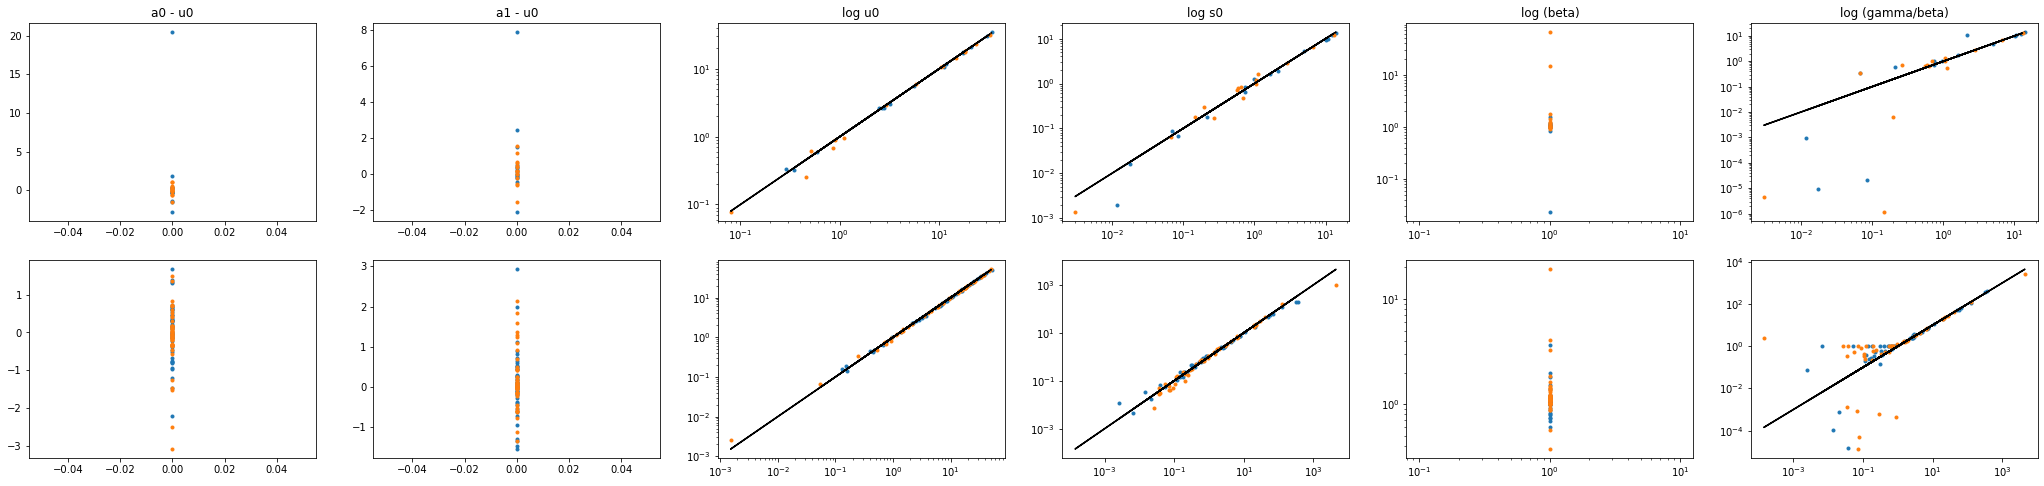

In [36]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K):
            axs[i,k].plot(theta[true_p:,k]-theta[true_p:,K],theta_hat[true_p:,k]-theta_hat[true_p:,K],'.')
            axs[i,k].plot(theta[true_p:,k]-theta[true_p:,K],theta[true_p:,k]-theta[true_p:,K],'k')
                
        axs[i,K].loglog(theta[true_p:,K],theta_hat[true_p:,K],'.')
        axs[i,K].loglog(theta[true_p:,K],theta[true_p:,K],'k')
        axs[i,K+1].loglog(theta[true_p:,K+1],theta_hat[true_p:,K+1],'.')
        axs[i,K+1].loglog(theta[true_p:,K+1],theta[true_p:,K+1],'k')


        axs[i,K+2].loglog(theta[true_p:,K+2],theta_hat[true_p:,K+2],'.')
        axs[i,K+2].loglog(theta[true_p:,K+2],theta[true_p:,K+2],'k')
        axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
        axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta[true_p:,K+3]/theta[true_p:,K+2],'k')

            
    # add title
    for k in range(K):
        axs[0,k].set_title("a"+str(k)+" - u0");    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma/beta)");
    

**plot informative genes**

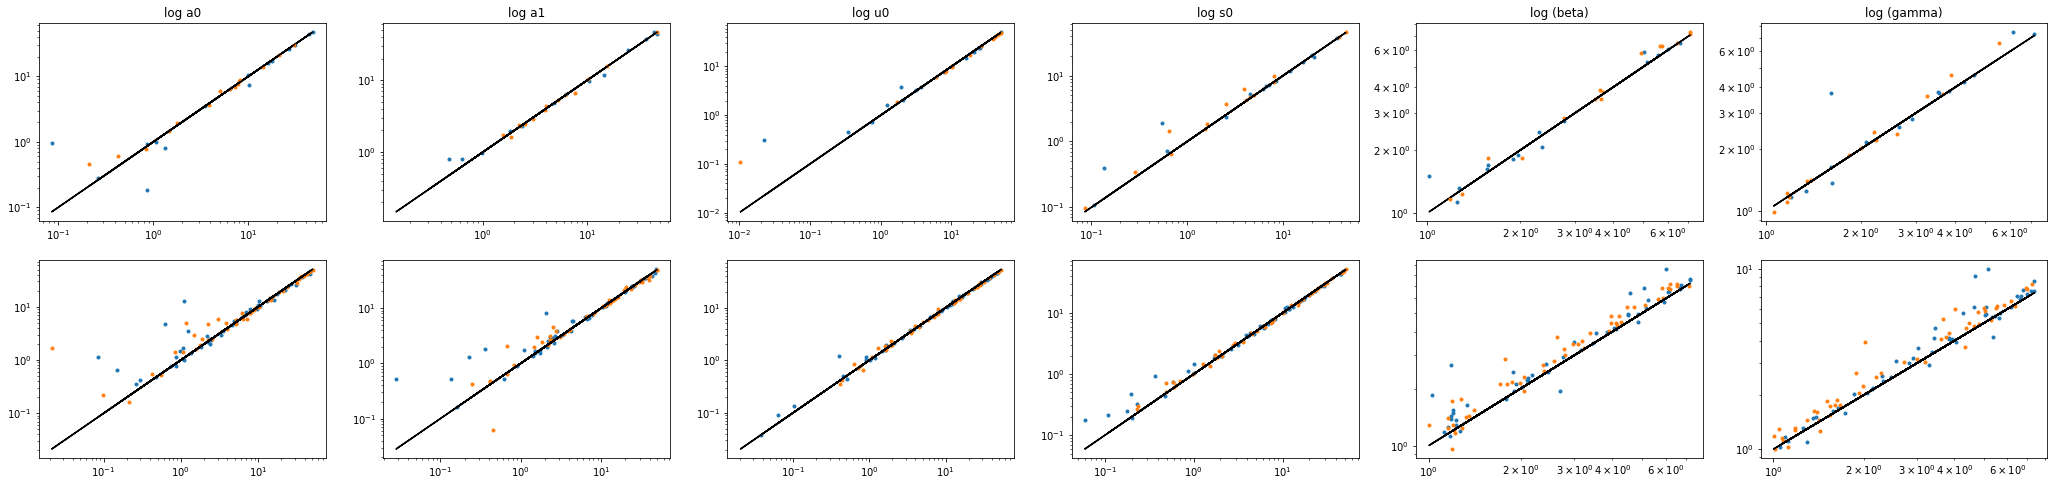

In [37]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K+4):
            axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
            axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma)");
    

### Penalty 0.001

In [72]:
thetas_3, theta_hats_3, weights_3 = get_fit_result(n=1500, rs=[0.01, 1/30], relative_penalty=0.001, add_null=True, seeds=[42,63], cores=30)

100%|██████████| 20/20 [04:50<00:00, 14.53s/it]


/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')


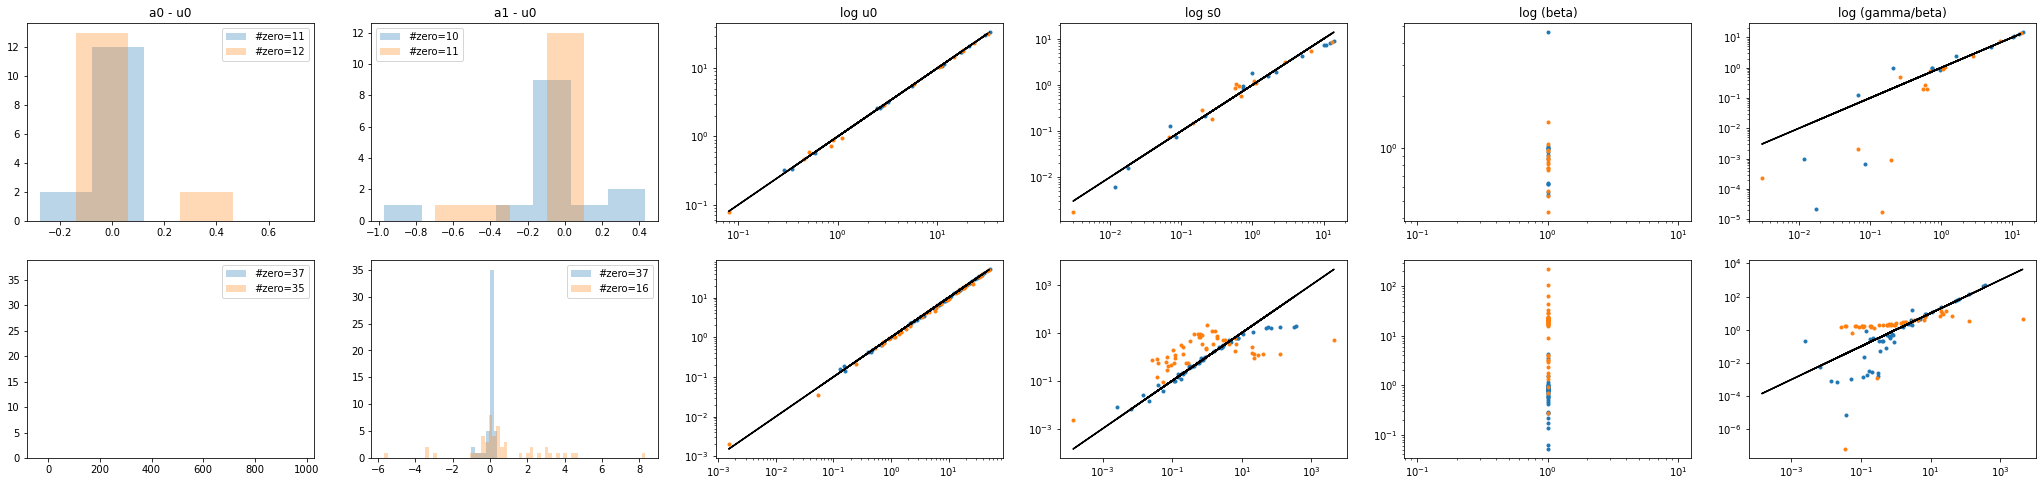

In [73]:
plot_uninformative_genes(thetas_3, theta_hats_3, weights_3, n=1500,rs=[0.01, 1/30],seeds=[42,63],K=2)

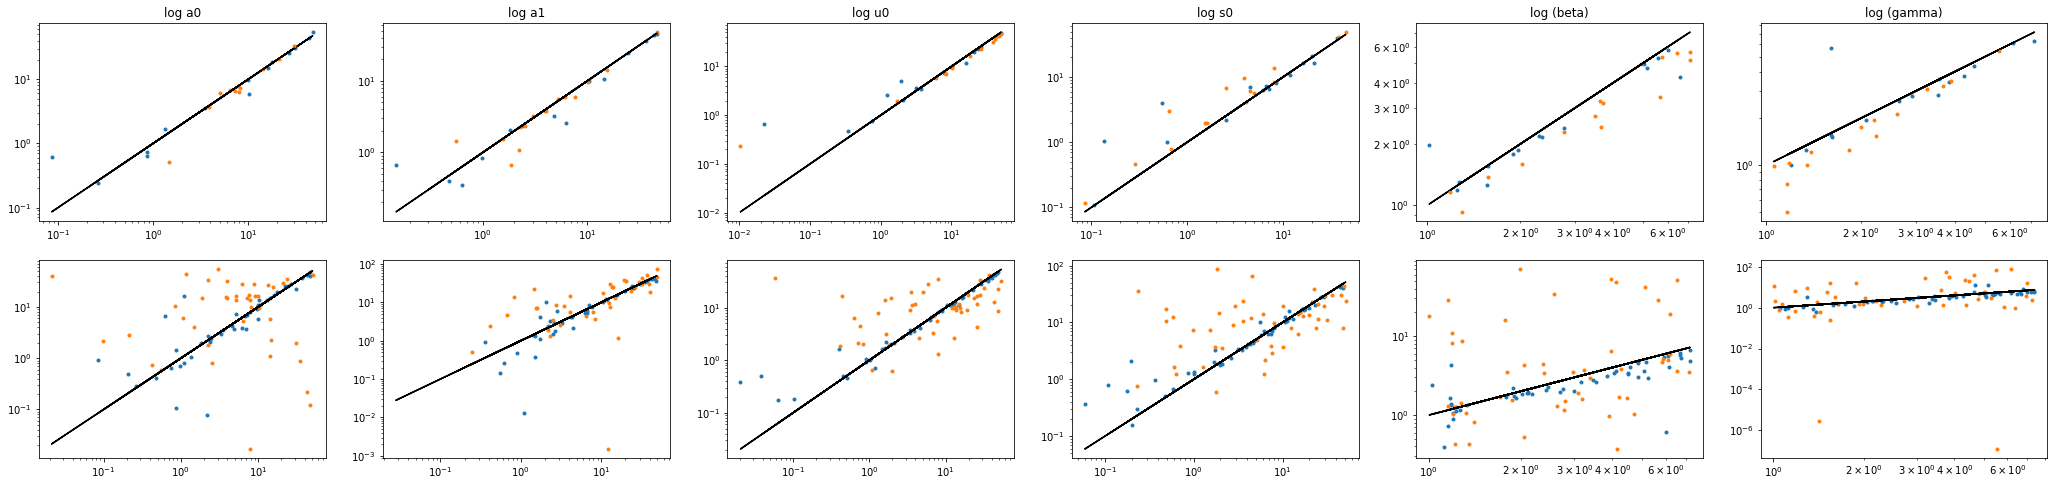

In [40]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K+4):
            axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
            axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma)");
    

### Penalty 0.01

In [41]:
thetas_2, theta_hats_2, weights_2 = get_fit_result(n=1500, rs=[0.01, 1/30], relative_penalty=0.01, add_null=True, seeds=[42,63], cores=30)

100%|██████████| 20/20 [05:10<00:00, 15.53s/it]


/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: invalid value encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')


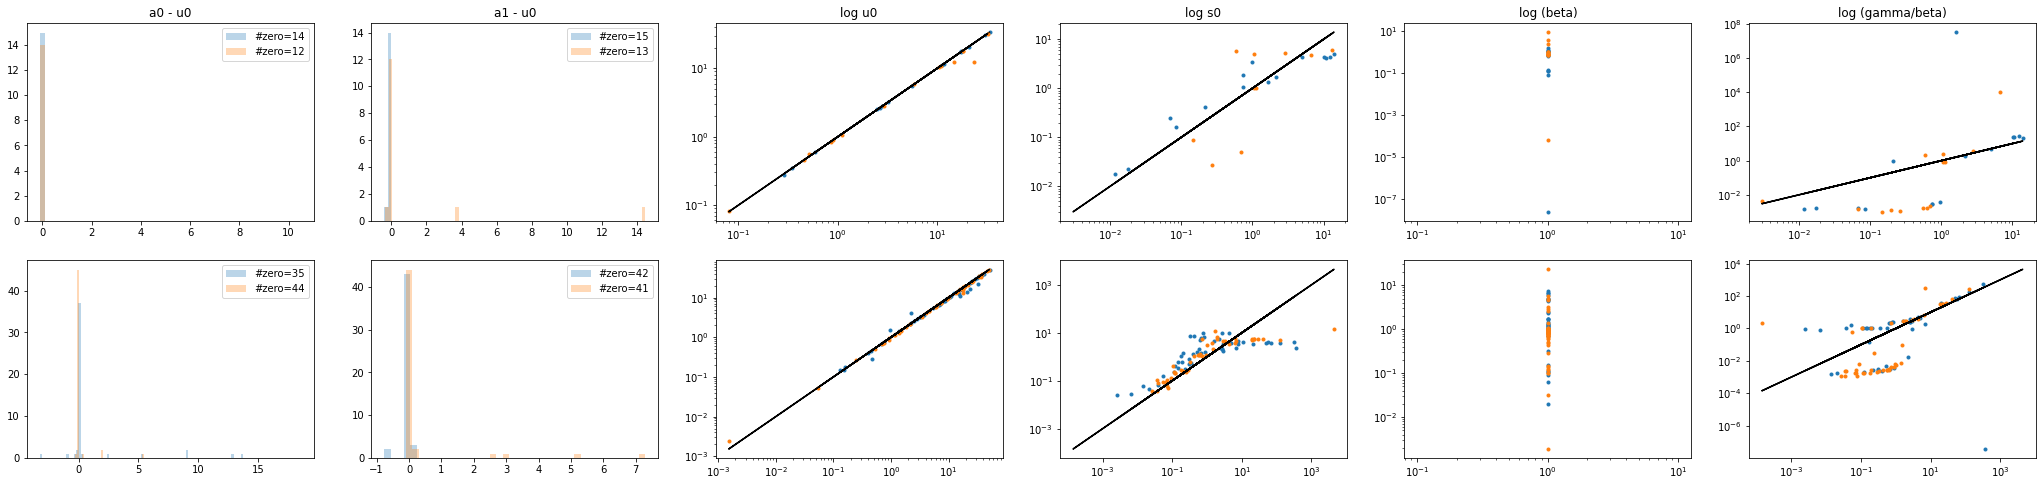

In [70]:
plot_uninformative_genes(thetas, theta_hats, weights, n=1500,rs=[0.01, 1/30],seeds=[42,63],K=2)

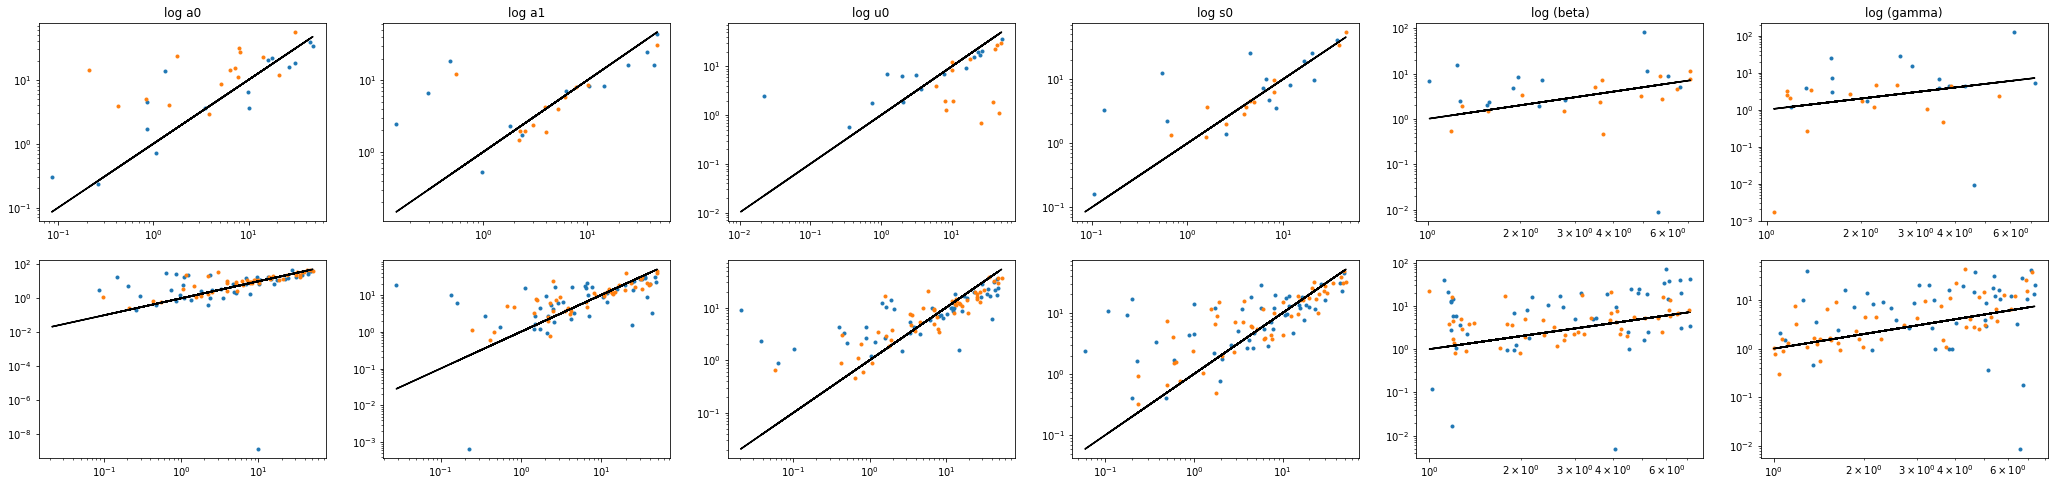

In [71]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K+4):
            axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
            axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma)");
    

### Penalty 0.1

100%|██████████| 20/20 [04:43<00:00, 14.19s/it]


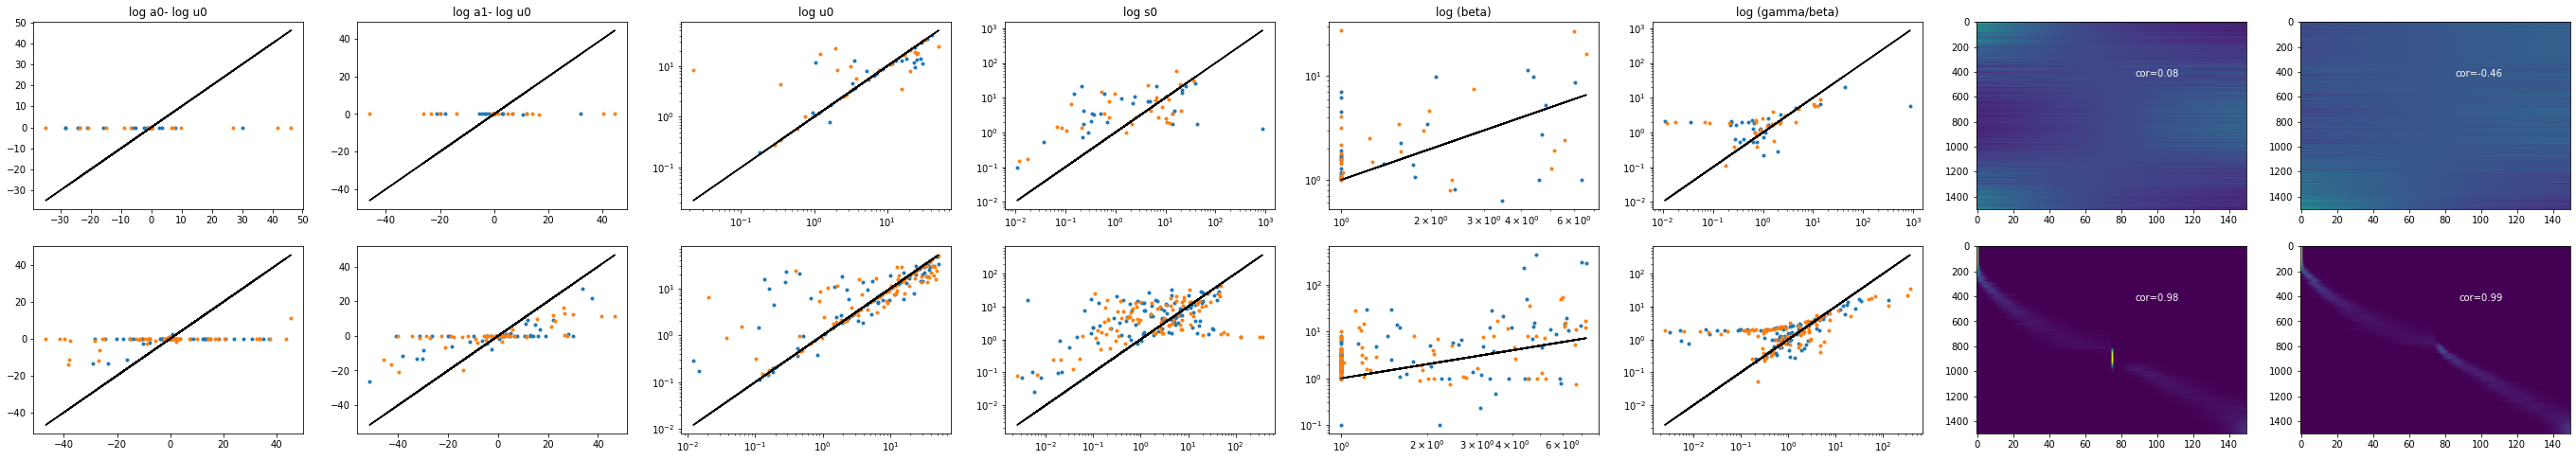

In [17]:
plot_fit_result(n=1500, rs=[0.01, 1/30], add_null=True, relative_penalty=0.1, seeds=[21,42], cores=40)